Importing libraries
----

In [215]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
import joblib

Read data
----

In [216]:
crop_data = pd.read_excel('datasets/crop_recommendation_new.xlsx', sheet_name=0)
region_data = pd.read_excel('datasets/crop_recommendation_new.xlsx', sheet_name=2)

In [217]:
crop_data.head()

,Id,Crop,Crop type,Altitude (masl),Annual rainfall (mm),temperature (C),pH,Soil type,N,P,K,Optimum soil moisture,Crop water need (mm/total growing period),Growing period (days),Irrigation required(%),Humidity(%),Crop calendar start (month),Crop calendar end (month)
0,1.0,Mango,Fruit,680-1400,890-1015,20-26,6.0-7.0,"well-draining, sandy loam, loamy soil",100,25,110,65–70,600-1200,100-150,NaN,60-80,November,January
1,2.0,Banana(Robusta),Fruit,"1,400–2,300",1500-2500,26-30,6.5-7.5,loamy - loam clay,322,73,118,75-77,1200-2200,300-365,30-40,60-80,Year-round,Year-round
2,3.0,Citrus,Fruit,900-2500,900-1200,23-30,6.0-7.0,loamy or sandy loam soils,22,12,57,60–70,900-1200,240-365,35-42,30-60,June,August
3,4.0,Apple,Fruit,120-3500,500-700,15-24,6.0-7.0,"well-drained, loamy soil",18,2,40,65–80,1150-1200,100-200,40-50,40-60,February,March
4,5.0,Pineapple,Fruit,>1100,700-1000,20-30,4.5-6.5,"sandy loam soil, well drained",150,45,530,60-80,600-1000,540-720,NaN,60-80,"January, April, July, October","January, April, July, October"


Data Cleaning
-----

In [218]:
# remove the unnecessary space
crop_data.columns = crop_data.columns.str.strip()

In [219]:
total_sectors_per_district = region_data['District'].value_counts().reset_index()

In [220]:
def clean_potassium_range(potassium_range):
    if isinstance(potassium_range, str):  # Ensure it's a string
        potassium_range = potassium_range.strip()  # Clean up leading/trailing spaces
        
        if '<' in potassium_range:
            upper_bound = float(potassium_range.split('<')[-1].strip())
            # Calculate the average of 0 and the upper bound
            return (0, (0 + upper_bound) / 2)
        elif '>' in potassium_range:
            lower_bound = float(potassium_range.split('>')[-1].strip())
            # Use an arbitrary high value to compute average, like double the lower_bound
            return (lower_bound, (lower_bound + lower_bound * 2) / 2)
        elif '-' in potassium_range:
            return tuple(map(float, potassium_range.split('-')))
        else:
            return (float(potassium_range), float(potassium_range))
    else:
        # Handle case where input is already a float
        return (float(potassium_range), float(potassium_range))

In [221]:
def clean_pH_range(ph_range):
    if isinstance(ph_range, str):  # Ensure it's a string
        ph_range = ph_range.strip()  # Clean up leading/trailing spaces
        
        if '<' in ph_range:
            upper_bound = float(ph_range.split('<')[-1].strip())
            # Calculate the average of 0 and the upper bound
            return (0, (0 + upper_bound) / 2)
        elif '>' in ph_range:
            lower_bound = float(ph_range.split('>')[-1].strip())
            # Use an arbitrary high value to compute average, like double the lower_bound
            return (lower_bound, (lower_bound + lower_bound * 2) / 2)
        elif '-' in ph_range:
            return tuple(map(float, ph_range.split('-')))
        else:
            return (float(ph_range), float(ph_range))
    else:
        # Handle case where input is already a float
        return (float(ph_range), float(ph_range))

In [222]:
def clean_phosphorus_range(p_range):
    if isinstance(p_range, str):
        if '<' in p_range:
            upper_bound = float(p_range.split('<')[-1].strip())
            # Calculate the average of 0 and the upper bound
            return (0, (0 + upper_bound) / 2)
        elif '>' in p_range:
            lower_bound = float(p_range.split('>')[-1].strip())
            # Use an arbitrary high value to compute average, like double the lower_bound
            return (lower_bound, (lower_bound + lower_bound * 2) / 2)
        elif '-' in p_range:
            return tuple(map(float, p_range.split('-')))
        else:
            return (float(p_range), float(p_range))
    else:
        return (float(p_range), float(p_range))

In [223]:
def clean_humidity_range(humidity_range):
    if isinstance(humidity_range, str):
        if '<' in humidity_range:
            upper_bound = float(humidity_range.split('<')[-1].strip())
            # Calculate the average of 0 and the upper bound
            return (0, (0 + upper_bound) / 2)
        elif '>' in humidity_range:
            lower_bound = float(humidity_range.split('>')[-1].strip())
            # Use an arbitrary high value to compute average, like double the lower_bound
            return (lower_bound, (lower_bound + lower_bound * 2) / 2)
        elif '-' in humidity_range:
            return tuple(map(float, humidity_range.split('-')))
        else:
            return (float(humidity_range), float(humidity_range))
    else:
        return (float(humidity_range), float(humidity_range))

In [224]:
def clean_temperature_range(temp_range):
    if isinstance(temp_range, str):
        if '<' in temp_range:
            upper_bound = float(temp_range.split('<')[-1].strip())
            # Calculate the average of 0 and the upper bound
            return (0, (0 + upper_bound) / 2)
        elif '>' in temp_range:
            lower_bound = float(temp_range.split('>')[-1].strip())
            # Use an arbitrary high value to compute average, like double the lower_bound
            return (lower_bound, (lower_bound + lower_bound * 2) / 2)
        elif '-' in temp_range:
            return tuple(map(float, temp_range.split('-')))
        else:
            return (float(temp_range), float(temp_range))
    else:
        return (float(temp_range), float(temp_range))

In [225]:
def clean_soil_moisture_range(moisture_range):
    if isinstance(moisture_range, str):
        if '<' in moisture_range:
            upper_bound = float(moisture_range.split('<')[-1].strip())
            # Calculate the average of 0 and the upper bound
            return (0, (0 + upper_bound) / 2)
        elif '>' in moisture_range:
            lower_bound = float(moisture_range.split('>')[-1].strip())
            # Use an arbitrary high value to compute average, like double the lower_bound
            return (lower_bound, (lower_bound + lower_bound * 2) / 2)
        elif '-' in moisture_range:
            return tuple(map(float, moisture_range.split('-')))
        else:
            return (float(moisture_range), float(moisture_range))
    else:
        return (float(moisture_range), float(moisture_range))

In [226]:
# Apply cleaning function to split potassium range into min and max
region_data[['potassium_min', 'potassium_max']] = region_data['Potassium(ppm)'].apply(clean_potassium_range).apply(pd.Series)

# Ensure the min and max columns are float type
region_data['potassium_min'] = region_data['potassium_min'].astype(float)
region_data['potassium_max'] = region_data['potassium_max'].astype(float)


In [227]:
# Apply cleaning function to split pH range into min and max
region_data[['phosphorus_min', 'phosphorus_max']] = region_data['Phosphorous(ppm)'].apply(clean_phosphorus_range).apply(pd.Series)

# Ensure the min and max columns are float type
region_data['phosphorus_min'] = region_data['phosphorus_min'].astype(float)
region_data['phosphorus_max'] = region_data['phosphorus_max'].astype(float)


In [228]:
# Apply cleaning function to split Phosphorous range into min and max
region_data[['pH_min', 'pH_max']] = region_data['pH'].apply(clean_pH_range).apply(pd.Series)

# Ensure the min and max columns are float type
region_data['pH_min'] = region_data['pH_min'].astype(float)
region_data['pH_max'] = region_data['pH_max'].astype(float)

In [229]:
# Clean and convert the pH column in crop_data
def convert_crop_ph(ph_value):
    if isinstance(ph_value, str) and '-' in ph_value:
        # If pH is in range format "6.0-7.0", convert it to the midpoint
        ph_min, ph_max = map(float, ph_value.split('-'))
        return (ph_min + ph_max) / 2  # Using the average of the range
    else:
        return float(ph_value)  # Ensure single values are floats

crop_data['pH'] = crop_data['pH'].apply(convert_crop_ph)

In [230]:
# def convert_temperature(temp_value):
#     if isinstance(temp_value, str) and '-' in temp_value:
#         temp_min, temp_max = map(float, temp_value.split('-'))
#         return (temp_min + temp_max) / 2
#     else:
#         try:
#             return pd.to_numeric(temp_value, errors='coerce')
#         except Exception as e:
#             print(f"Error converting value: {temp_value} -> {e}")
#             return None

# crop_data['temperature (C)'] = crop_data['temperature (C)'].apply(convert_temperature)

In [231]:
# def convert_crop_moisture(moisture_value):
#     try:
#         if isinstance(moisture_value, str) and '-' in moisture_value:
#             moisture_min, moisture_max = map(float, moisture_value.split('-'))
#             return (moisture_min + moisture_max) / 2
#         elif moisture_value == '-':  # Check for hyphen followed by empty string
#             return None  # Or handle it as you see fit
#         else:
#             return pd.to_numeric(moisture_value, errors='coerce')
#     except ValueError as e:
#         print(f"Error converting value: {moisture_value} -> {e}")
#         return None

# crop_data['Optimum soil moisture'] = crop_data['Optimum soil moisture'].apply(convert_crop_moisture)

In [232]:
# Define a function to clean the range values or '>' values
def clean_range_or_greater_than(value):
    if isinstance(value, str):
        if '-' in value:
            # If the value is a range (e.g., '680-1400'), calculate the midpoint
            value_min, value_max = map(float, value.split('-'))
            return (value_min + value_max) / 2
        elif '>' in value:
            # If the value starts with '>' (e.g., '>4500'), remove the '>' and return the numeric part
            return float(value.replace('>', '').strip())
    # If the value is already a number (or can be converted), just return it
    try:
        return pd.to_numeric(value, errors='coerce')
    except:
        return None

In [233]:
# Apply the cleaning function to the relevant columns
crop_data['Altitude (masl)'] = crop_data['Altitude (masl)'].apply(clean_range_or_greater_than)
crop_data['Annual rainfall (mm)'] = crop_data['Annual rainfall (mm)'].apply(clean_range_or_greater_than)

In [234]:
def match_ph_range(row, region_data):
    ph_min, ph_max = row['pH_cleaned']
    
    # Match if any overlap exists between the pH range and the potassium range in region_data
    return region_data[
        (region_data['pH_min'] <= ph_max) &
        (region_data['pH_max'] >= ph_min)
    ]

In [235]:
def match_potassium_range(row, region_data):
    k_min, k_max = row['K_cleaned']
    
    # Match if any overlap exists between the K range and the potassium range in region_data
    return region_data[
        (region_data['potassium_min'] <= k_max) &  # Potassium min must be <= K max
        (region_data['potassium_max'] >= k_min)    # Potassium max must be >= K min
    ]

In [236]:
# Merge phosphorus data with region_data
def match_phosphorus_range(row, region_data):
    p_min, p_max = row['P_cleaned']
    
    return region_data[
        (region_data['phosphorus_min'] <= p_max) &
        (region_data['phosphorus_max'] >= p_min)
    ]

In [237]:
# Function to parse the humidity range from strings like '60-70' to numerical min and max
def parse_humidity_range(humidity_range):
    # Convert to string if it's not already, and handle cases where it might be NaN or a float
    if isinstance(humidity_range, float) or pd.isna(humidity_range):
        return None, None
    try:
        min_value, max_value = map(float, str(humidity_range).split('-'))
        return min_value, max_value
    except ValueError:
        # If the split fails, return None for both values
        return None, None

# Apply the parsing function to create min and max columns in crop_data
crop_data[['Humidity_min', 'Humidity_max']] = crop_data['Humidity(%)'].apply(
    lambda x: pd.Series(parse_humidity_range(x))
)


In [238]:
# Function to parse the humidity range from strings like '60-70' to numerical min and max
def parse_temperature_range(temperature_range):
    # Convert to string if it's not already, and handle cases where it might be NaN or a float
    if isinstance(temperature_range, float) or pd.isna(temperature_range):
        return None, None
    try:
        min_value, max_value = map(float, str(temperature_range).split('-'))
        return min_value, max_value
    except ValueError:
        # If the split fails, return None for both values
        return None, None

# Apply the parsing function to create min and max columns in crop_data
crop_data[['Temperature_min', 'Temperature_max']] = crop_data['temperature (C)'].apply(
    lambda x: pd.Series(parse_temperature_range(x))
)


In [239]:
# Function to parse the humidity range from strings like '60-70' to numerical min and max
def parse_moisture_range(moisture_range):
    # Convert to string if it's not already, and handle cases where it might be NaN or a float
    if isinstance(moisture_range, float) or pd.isna(moisture_range):
        return None, None
    try:
        min_value, max_value = map(float, str(moisture_range).split('-'))
        return min_value, max_value
    except ValueError:
        # If the split fails, return None for both values
        return None, None

# Apply the parsing function to create min and max columns in crop_data
crop_data[['Moisture_min', 'Moisture_max']] = crop_data['Optimum soil moisture'].apply(
    lambda x: pd.Series(parse_moisture_range(x))
)

In [240]:
region_data.columns

Index(['Longitude', 'Latitude', 'Prov_ID', 'Province', 'Dist_ID', 'District',
       'Sect_ID', 'Sector', 'Acid Saturation(%)', 'AcidSat', 'Boron (ppm)',
       'Calcium(%)', 'Calcium(ppm)', 'Copper (ppm)', 'Magnessium(%)',
       'Magnessium(ppm)', 'Manganese(ppm)', 'Manganese', 'Organic Matter(%)',
       'pH', 'Phosphorous(ppm)', 'Potassium (%)', 'Potassium(ppm)',
       'Sulphur (ppm)', 'Zinc (ppm)', 'Humidity', 'Rainfall', 'Temperature',
       'Elevation', 'Soil_Moisture', 'potassium_min', 'potassium_max',
       'phosphorus_min', 'phosphorus_max', 'pH_min', 'pH_max'],
      dtype='object')

In [241]:
# Function to match humidity range between crop data and region data
def match_humidity_range(crop_row, region_data):
    min_humidity = crop_row['Humidity_min']
    max_humidity = crop_row['Humidity_max']
    # Filter region_data to find humidity values within the min and max range
    matching_regions = region_data[
        (region_data['Humidity'] >= min_humidity) & 
        (region_data['Humidity'] <= max_humidity)
    ]
    return matching_regions


In [242]:
# Function to match temperature range between crop data and region data
def match_temperature_range(crop_row, region_data):
    min_temperature = crop_row['Temperature_min']
    max_temperature = crop_row['Temperature_max']
    # Filter region_data to find temperature values within the min and max range
    matching_regions = region_data[
        (region_data['Temperature'] >= min_temperature) & 
        (region_data['Temperature'] <= max_temperature)
    ]
    return matching_regions


In [243]:
# Function to match soil moisture range between crop data and region data
def match_moisture_range(crop_row, region_data):
    min_moisture = crop_row['Moisture_min']
    max_moisture = crop_row['Moisture_max']
    # Filter region_data to find moisture values within the min and max range
    matching_regions = region_data[
        (region_data['Soil_Moisture'] >= min_moisture) & 
        (region_data['Soil_Moisture'] <= max_moisture)
    ]
    return matching_regions

In [244]:
# Store merged rows where humidity ranges match
merged_rows_humidity = []

# Iterate through each row in crop_data
for _, crop_row in crop_data.iterrows():
    # Find matching rows in region_data based on humidity range
    matching_regions_humidity = match_humidity_range(crop_row, region_data)
    
    # Merge each matched region row with the crop row
    for _, region_row in matching_regions_humidity.iterrows():
        # Combine the crop data and matching region data into a single dictionary
        merged_data = {**crop_row.to_dict(), **region_row.to_dict()}
        merged_rows_humidity.append(merged_data)


In [245]:
# Store merged rows where temperature ranges match
merged_rows_temperature = []

# Iterate through each row in crop_data
for _, crop_row in crop_data.iterrows():
    # Find matching rows in region_data based on humidity range
    matching_regions_temperature = match_temperature_range(crop_row, region_data)
    
    # Merge each matched region row with the crop row
    for _, region_row in matching_regions_temperature.iterrows():
        # Combine the crop data and matching region data into a single dictionary
        merged_data = {**crop_row.to_dict(), **region_row.to_dict()}
        merged_rows_temperature.append(merged_data)

In [246]:
# Store merged rows where soil moisture ranges match
merged_rows_moisture = []

# Iterate through each row in crop_data
for _, crop_row in crop_data.iterrows():
    # Find matching rows in region_data based on moisture range
    matching_regions_moisture = match_moisture_range(crop_row, region_data)
    
    # Merge each matched region row with the crop row
    for _, region_row in matching_regions_moisture.iterrows():
        # Combine the crop data and matching region data into a single dictionary
        merged_data = {**crop_row.to_dict(), **region_row.to_dict()}
        merged_rows_moisture.append(merged_data)

In [247]:
# # Merge temperature data with region_data
# def match_temperature_range(row, region_data):
#     temp_min, temp_max = row['Temp_cleaned']
    
#     return region_data[
#         (region_data['temperature_min'] <= temp_max) &
#         (region_data['temperature_max'] >= temp_min)
#     ]

In [248]:
# # Merge soil moisture data with region_data
# def match_moisture_range(row, region_data):
#     moisture_min, moisture_max = row['Moisture_cleaned']
    
#     return region_data[
#         (region_data['moisture_min'] <= moisture_max) &
#         (region_data['moisture_max'] >= moisture_min)
#     ]

In [249]:
# Clean K values in crop_data to handle ranges
crop_data['K_cleaned'] = crop_data['K'].apply(clean_potassium_range)

# Merge crop_data with region_data based on K
merged_rows_potassium = []
for _, crop_row in crop_data.iterrows():
    matching_regions_potassium = match_potassium_range(crop_row, region_data)
    for _, region_row in matching_regions_potassium.iterrows():
        # Combine the rows of crop_data and region_data where the K matches
        merged_rows_potassium.append({**crop_row.to_dict(), **region_row.to_dict()})

In [250]:
# Clean pH values in crop_data
crop_data['pH_cleaned'] = crop_data['pH'].apply(clean_pH_range)

# Merge crop_data with region_data based on pH
merged_rows_ph = []
for _, crop_row in crop_data.iterrows():
    matching_regions_ph = match_ph_range(crop_row, region_data)
    for _, region_row in matching_regions_ph.iterrows():
        # Combine the rows of crop_data and region_data where pH matches
        merged_rows_ph.append({**crop_row.to_dict(), **region_row.to_dict()})

In [251]:
# Apply cleaning function to phosphorus values
crop_data['P_cleaned'] = crop_data['P'].apply(clean_phosphorus_range)

merged_rows_phosphorus = []
for _, crop_row in crop_data.iterrows():
    matching_regions_phosphorus = match_phosphorus_range(crop_row, region_data)
    for _, region_row in matching_regions_phosphorus.iterrows():
        merged_rows_phosphorus.append({**crop_row.to_dict(), **region_row.to_dict()})

In [252]:
# # Apply cleaning function to temperature values
# crop_data['Temp_cleaned'] = crop_data['temperature (C)'].apply(clean_temperature_range)

# merged_rows_temperature = []
# for _, crop_row in crop_data.iterrows():
#     matching_regions_temperature = match_temperature_range(crop_row, region_data)
#     for _, region_row in matching_regions_temperature.iterrows():
#         merged_rows_temperature.append({**crop_row.to_dict(), **region_row.to_dict()})

In [253]:
# # Apply cleaning function to soil moisture values
# crop_data['Moisture_cleaned'] = crop_data['P'].apply(clean_soil_moisture_range)

# merged_rows_moisture = []
# for _, crop_row in crop_data.iterrows():
#     matching_regions_moisture = match_moisture_range(crop_row, region_data)
#     for _, region_row in matching_regions_moisture.iterrows():
#         merged_rows_moisture.append({**crop_row.to_dict(), **region_row.to_dict()})

In [254]:
# Convert merged_rows into a DataFrame
merged_data_potassium = pd.DataFrame(merged_rows_potassium)
merged_data_ph = pd.DataFrame(merged_rows_ph)
merged_data_phosphorus = pd.DataFrame(merged_rows_phosphorus)
merged_data_humidity = pd.DataFrame(merged_rows_humidity)
merged_data_temperature = pd.DataFrame(merged_rows_temperature)
merged_data_moisture = pd.DataFrame(merged_rows_moisture)

Data Processing
-----

In [255]:
# Normalize/scale numerical features for potassium, pH, and phosphorus datasets
numerical_columns = ['Altitude (masl)', 'Annual rainfall (mm)', 'potassium_min', 'potassium_max', 'pH_min', 'pH_max', 'phosphorus_min', 'phosphorus_max', 'Humidity_min', 'Humidity_max', 'Temperature_min', 'Temperature_max', 'Moisture_min', 'Moisture_max']

# Replace infinity with a large finite value in the potassium, pH, and phosphorus datasets
large_value_potassium = 250  # Set an appropriate large value for your data context
large_value_pH = 8
large_value_phosphorous = 50
large_value_humidity = 100
large_value_temp = 37
large_value_moisture = 100
merged_data_potassium.replace([np.inf, -np.inf], large_value_potassium, inplace=True)
merged_data_ph.replace([np.inf, -np.inf], large_value_pH, inplace=True)
merged_data_phosphorus.replace([np.inf, -np.inf], large_value_phosphorous, inplace=True)
merged_data_humidity.replace([np.inf, -np.inf], large_value_humidity, inplace=True)
merged_data_temperature.replace([np.inf, -np.inf], large_value_temp, inplace=True)
merged_data_moisture.replace([np.inf, -np.inf], large_value_moisture, inplace=True)

# Optionally, you can also clip any values that are too large for all numerical columns
max_value = 1000  # Set an appropriate maximum threshold
merged_data_potassium[numerical_columns] = merged_data_potassium[numerical_columns].clip(upper=max_value)
merged_data_ph[numerical_columns] = merged_data_ph[numerical_columns].clip(upper=max_value)
merged_data_phosphorus[numerical_columns] = merged_data_phosphorus[numerical_columns].clip(upper=max_value)
merged_data_humidity[numerical_columns] = merged_data_humidity[numerical_columns].clip(upper=max_value)
merged_data_temperature[numerical_columns] = merged_data_temperature[numerical_columns].clip(upper=max_value)
merged_data_moisture[numerical_columns] = merged_data_moisture[numerical_columns].clip(upper=max_value)

In [256]:
merged_data_potassium['Temperature_max']

0       26.0
1       26.0
2       26.0
3       26.0
4       26.0
        ... 
4458    22.0
4459    22.0
4460    22.0
4461    22.0
4462    22.0
Name: Temperature_max, Length: 4463, dtype: float64

Feature engineering
----

In [257]:
# # Now, proceed with scaling the numerical columns
# scaler = StandardScaler()

# # Apply scaling to the numerical columns for all datasets
# merged_data_potassium[numerical_columns] = scaler.fit_transform(merged_data_potassium[numerical_columns])
# merged_data_ph[numerical_columns] = scaler.fit_transform(merged_data_ph[numerical_columns])
# merged_data_phosphorus[numerical_columns] = scaler.fit_transform(merged_data_phosphorus[numerical_columns])
# merged_data_humidity[numerical_columns] = scaler.fit_transform(merged_data_humidity[numerical_columns])
# merged_data_temperature[numerical_columns] = scaler.fit_transform(merged_data_temperature[numerical_columns])
# merged_data_moisture[numerical_columns] = scaler.fit_transform(merged_data_moisture[numerical_columns])

In [258]:
merged_data_potassium['Temperature_max']

0       26.0
1       26.0
2       26.0
3       26.0
4       26.0
        ... 
4458    22.0
4459    22.0
4460    22.0
4461    22.0
4462    22.0
Name: Temperature_max, Length: 4463, dtype: float64

Getting the Base dataset (base_data)
----

In [259]:
# Get the size of each dataset
potassium_size = len(merged_data_potassium)
ph_size = len(merged_data_ph)
phosphorus_size = len(merged_data_phosphorus)
humidity_size = len(merged_data_humidity)
temperature_size = len(merged_data_temperature)
moisture_size = len(merged_data_moisture)

# Store sizes in a dictionary for easy comparison
dataset_sizes = {
    "potassium": potassium_size,
    "ph": ph_size,
    "phosphorus": phosphorus_size,
    "humidity": humidity_size,
    "temperature": temperature_size,
    "moisture": moisture_size
}

# Identify the dataset with the largest size
largest_dataset_name = max(dataset_sizes, key=dataset_sizes.get)

# Create a base copy of the largest dataset
if largest_dataset_name == "potassium":
    base_data = merged_data_potassium.copy()
elif largest_dataset_name == "ph":
    base_data = merged_data_ph.copy()
elif largest_dataset_name == "phosphorus":
    base_data = merged_data_phosphorus.copy()
elif largest_dataset_name == "humidity":
    base_data = merged_data_humidity.copy()
elif largest_dataset_name == "temperature":
    base_data = merged_data_temperature.copy()
elif largest_dataset_name == "moisture":
    base_data = merged_data_moisture.copy()

Visualization
-----

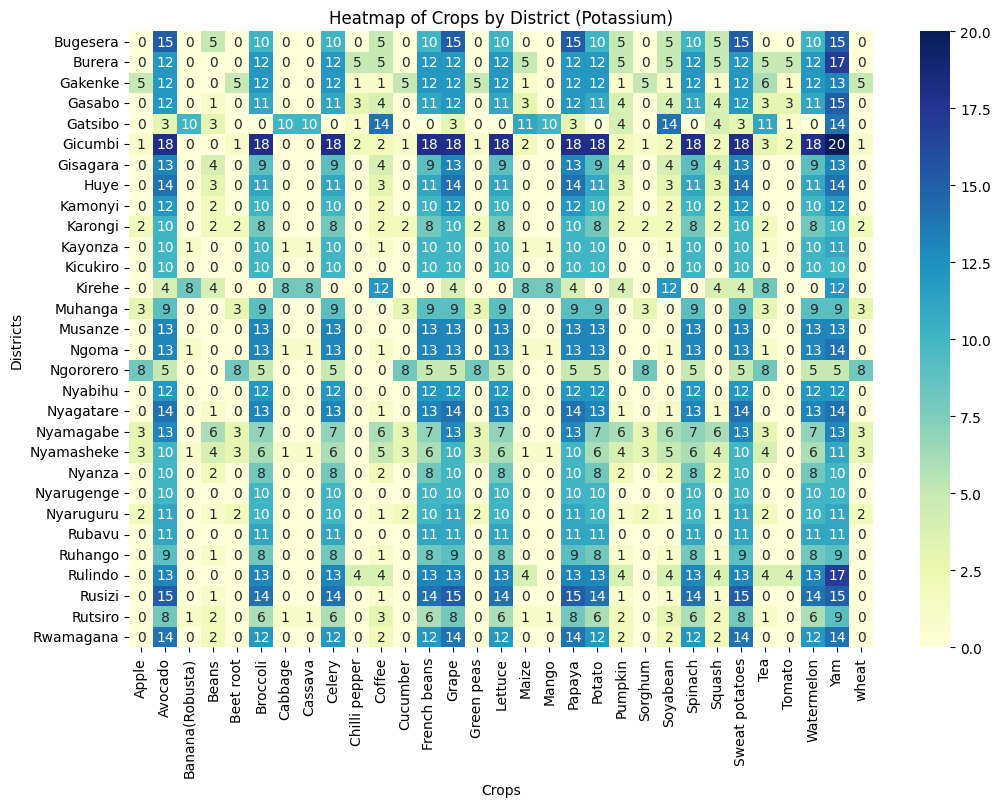

In [260]:
crops_per_district_potassium = merged_data_potassium.groupby(['District', 'Crop']).size().reset_index(name='Count')
heatmap_data_potassium = crops_per_district_potassium.pivot(index="District", columns="Crop", values="Count").fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_potassium, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Heatmap of Crops by District (Potassium)')
plt.xlabel('Crops')
plt.ylabel('Districts')
plt.show()

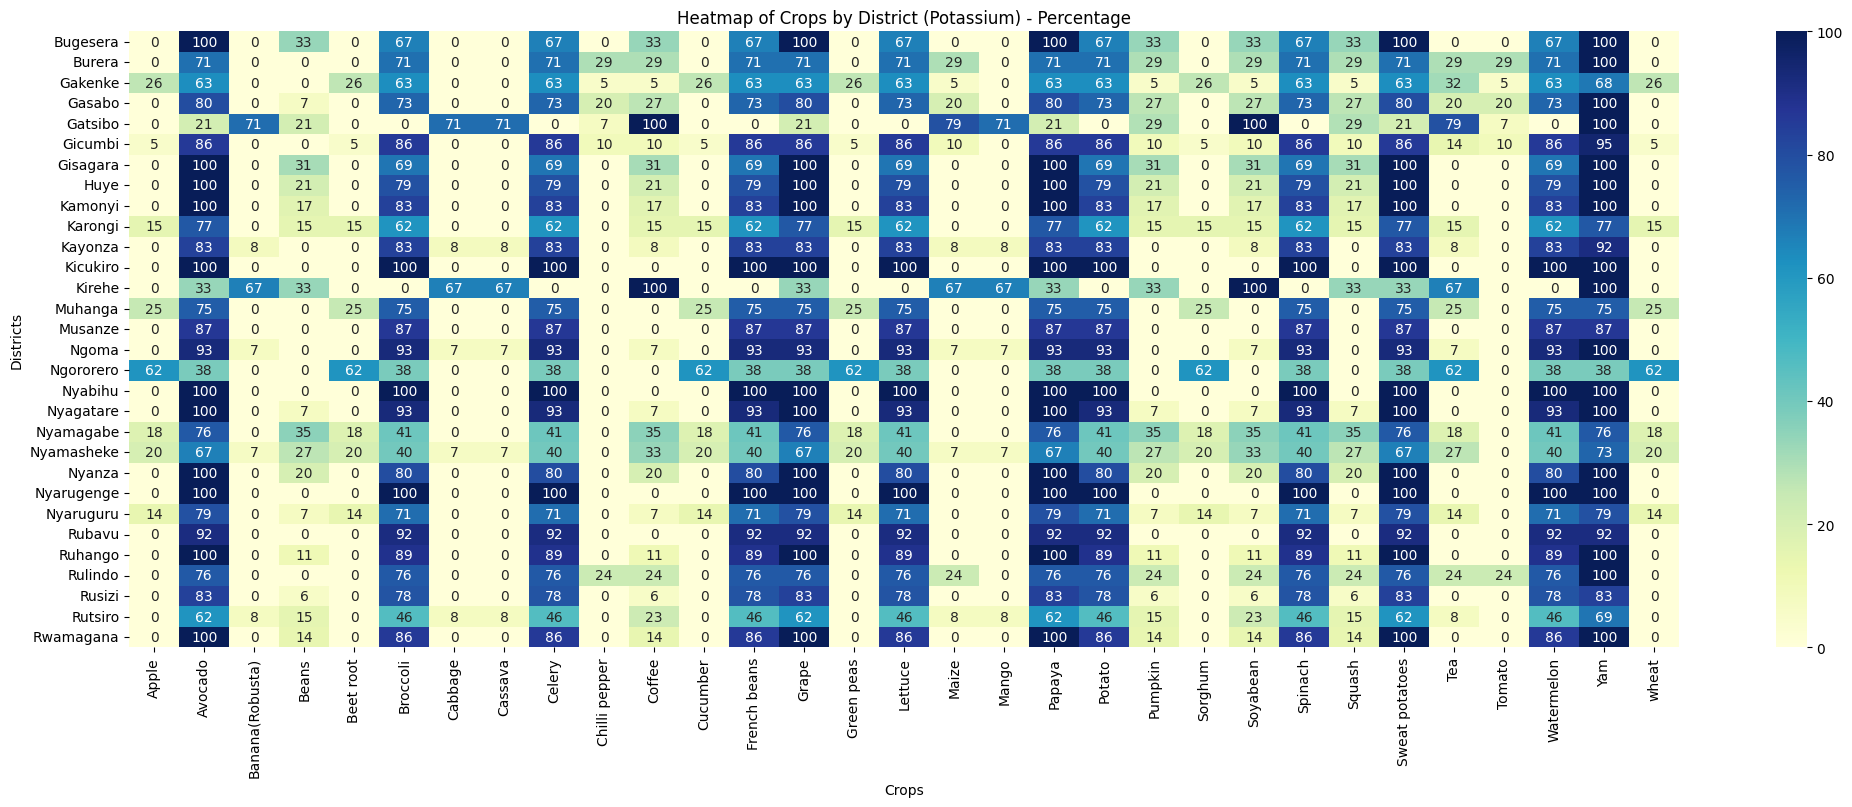

In [261]:
# Group by 'District' and 'Crop' to get the count of each crop in each district
crops_per_district_potassium = merged_data_potassium.groupby(['District', 'Crop']).size().reset_index(name='Count')

# Calculate the total number of sectors per district (ignore crops)
total_sectors_per_district.columns = ['District', 'Total_Sectors']

# Merge the crop counts with the total number of sectors per district
crops_per_district_potassium = crops_per_district_potassium.merge(total_sectors_per_district, on='District')

# Calculate the percentage of each crop in each district
crops_per_district_potassium['Percentage'] = (crops_per_district_potassium['Count'] / crops_per_district_potassium['Total_Sectors']) * 100

# Pivot to create a dataframe suitable for heatmap visualization
heatmap_data_potassium = crops_per_district_potassium.pivot(index="District", columns="Crop", values="Percentage").fillna(0)

# Create the heatmap with reduced decimal places
plt.figure(figsize=(25, 8))
sns.heatmap(heatmap_data_potassium, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Heatmap of Crops by District (Potassium) - Percentage')
plt.xlabel('Crops')
plt.ylabel('Districts')
plt.show()

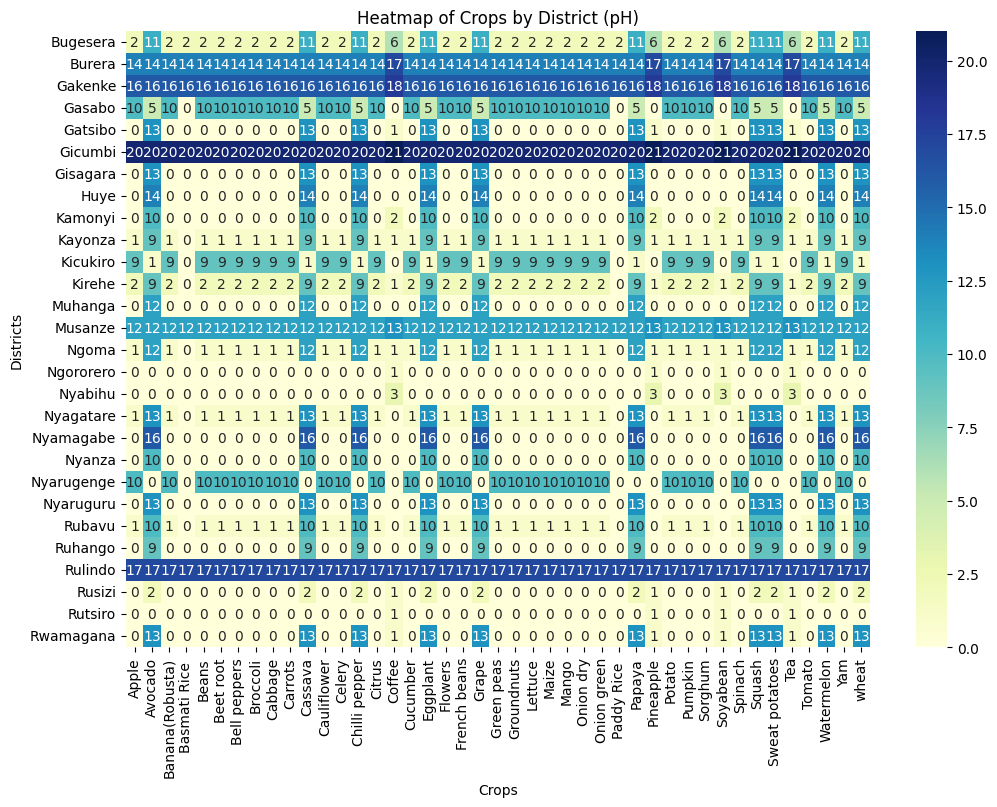

In [262]:
crops_per_district_ph = merged_data_ph.groupby(['District', 'Crop']).size().reset_index(name='Count')
heatmap_data_ph = crops_per_district_ph.pivot(index="District", columns="Crop", values="Count").fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_ph, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Heatmap of Crops by District (pH)')
plt.xlabel('Crops')
plt.ylabel('Districts')
plt.show()

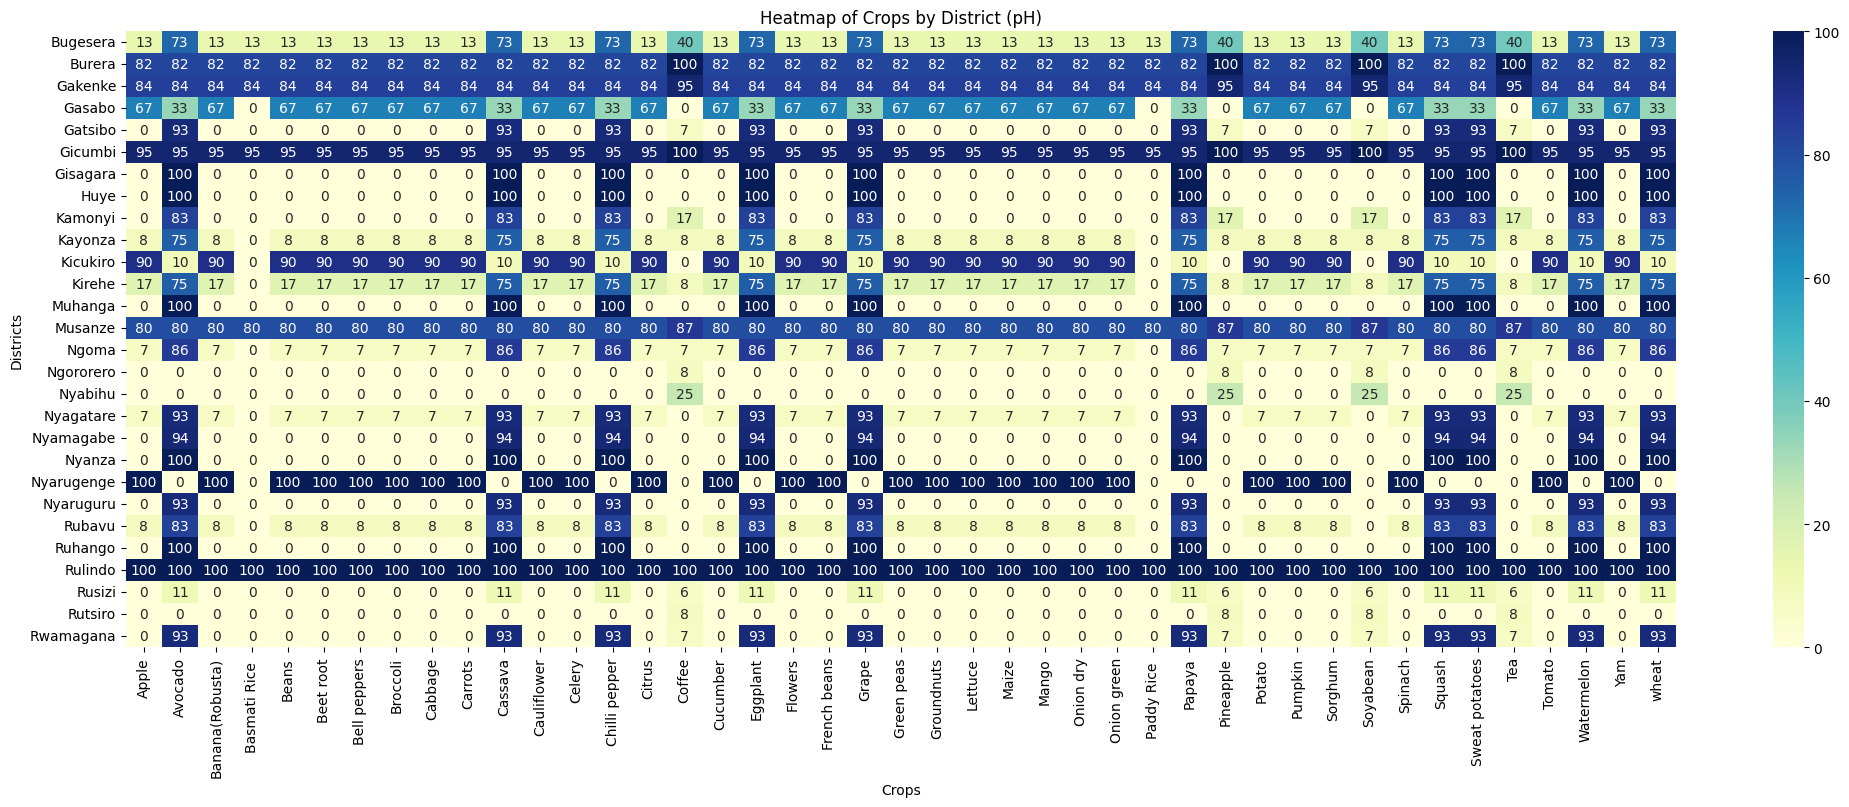

In [263]:
# Group by 'District' and 'Crop' to get the count of each crop in each district
crops_per_district_ph = merged_data_ph.groupby(['District', 'Crop']).size().reset_index(name='Count')

# Calculate the total number of sectors per district (ignore crops)
total_sectors_per_district.columns = ['District', 'Total_Sectors']

# Merge the crop counts with the total number of sectors per district
crops_per_district_ph = crops_per_district_ph.merge(total_sectors_per_district, on='District')

# Calculate the percentage of each crop in each district
crops_per_district_ph['Percentage'] = (crops_per_district_ph['Count'] / crops_per_district_ph['Total_Sectors']) * 100

# Pivot to create a dataframe suitable for heatmap visualization
heatmap_data_ph = crops_per_district_ph.pivot(index="District", columns="Crop", values="Percentage").fillna(0)

# Create the heatmap with reduced decimal places
plt.figure(figsize=(25, 8))
sns.heatmap(heatmap_data_ph, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Heatmap of Crops by District (pH)')
plt.xlabel('Crops')
plt.ylabel('Districts')
plt.show()

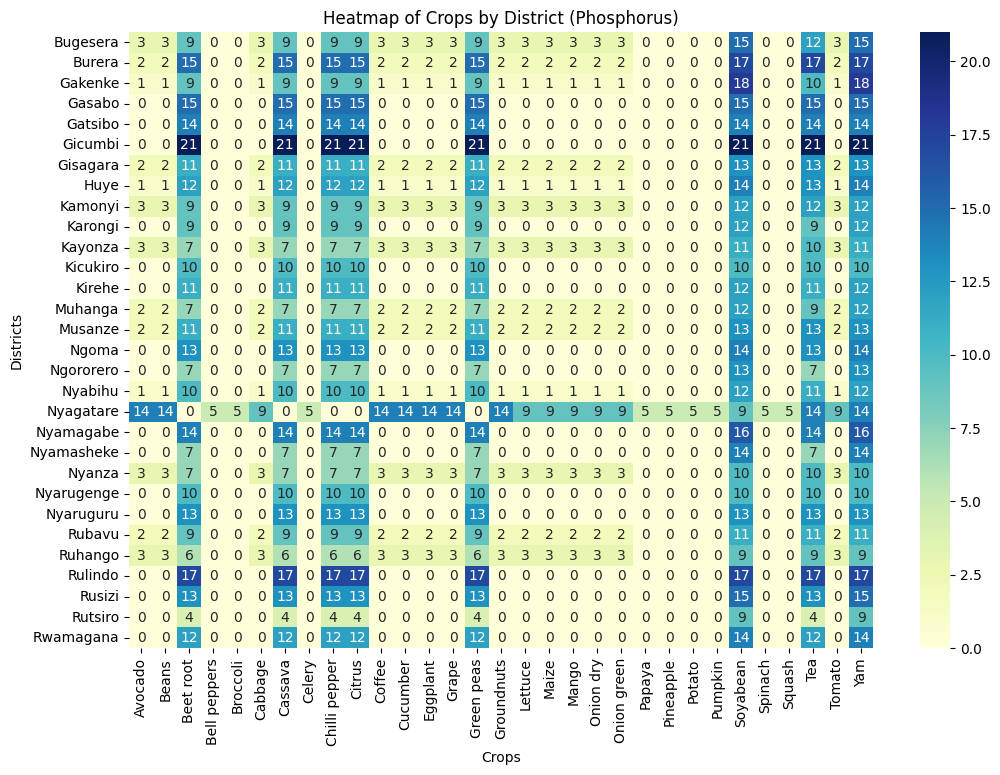

In [264]:
crops_per_district_phosphorus = merged_data_phosphorus.groupby(['District', 'Crop']).size().reset_index(name='Count')
heatmap_data_phosphorus = crops_per_district_phosphorus.pivot(index="District", columns="Crop", values="Count").fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_phosphorus, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Heatmap of Crops by District (Phosphorus)')
plt.xlabel('Crops')
plt.ylabel('Districts')
plt.show()

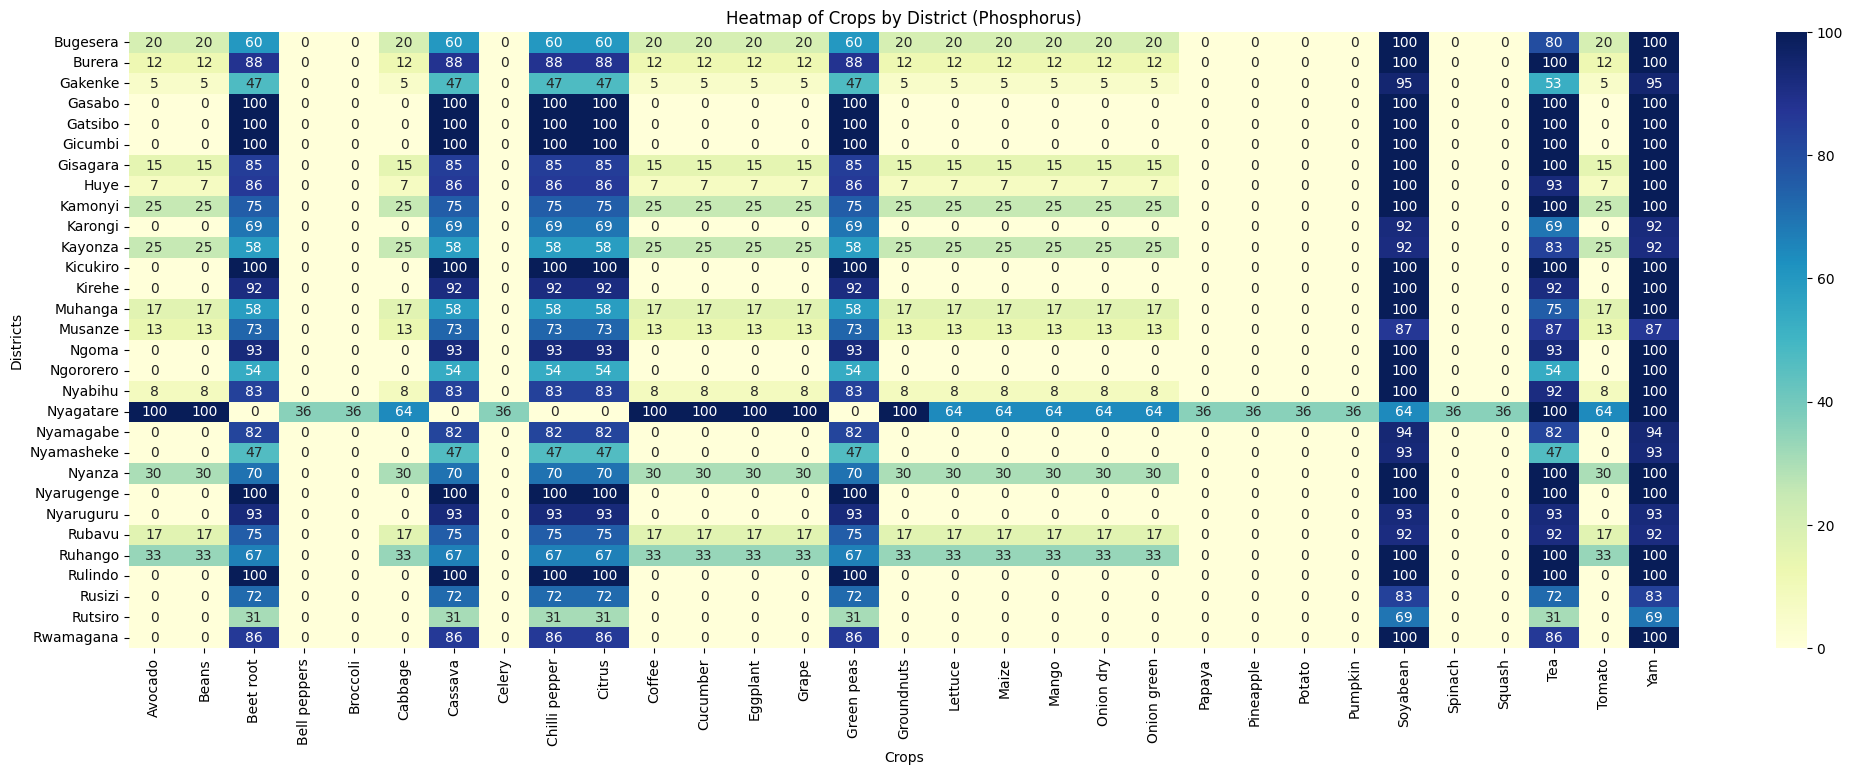

In [265]:
# Group by 'District' and 'Crop' to get the count of each crop in each district
crops_per_district_phosphorus = merged_data_phosphorus.groupby(['District', 'Crop']).size().reset_index(name='Count')

# Calculate the total number of sectors per district (ignore crops)
total_sectors_per_district.columns = ['District', 'Total_Sectors']

# Merge the crop counts with the total number of sectors per district
crops_per_district_phosphorus = crops_per_district_phosphorus.merge(total_sectors_per_district, on='District')

# Calculate the percentage of each crop in each district
crops_per_district_phosphorus['Percentage'] = (crops_per_district_phosphorus['Count'] / crops_per_district_phosphorus['Total_Sectors']) * 100

# Pivot to create a dataframe suitable for heatmap visualization
heatmap_data_phosphorus = crops_per_district_phosphorus.pivot(index="District", columns="Crop", values="Percentage").fillna(0)

# Create the heatmap with reduced decimal places
plt.figure(figsize=(25, 8))
sns.heatmap(heatmap_data_phosphorus, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Heatmap of Crops by District (Phosphorus)')
plt.xlabel('Crops')
plt.ylabel('Districts')
plt.show()

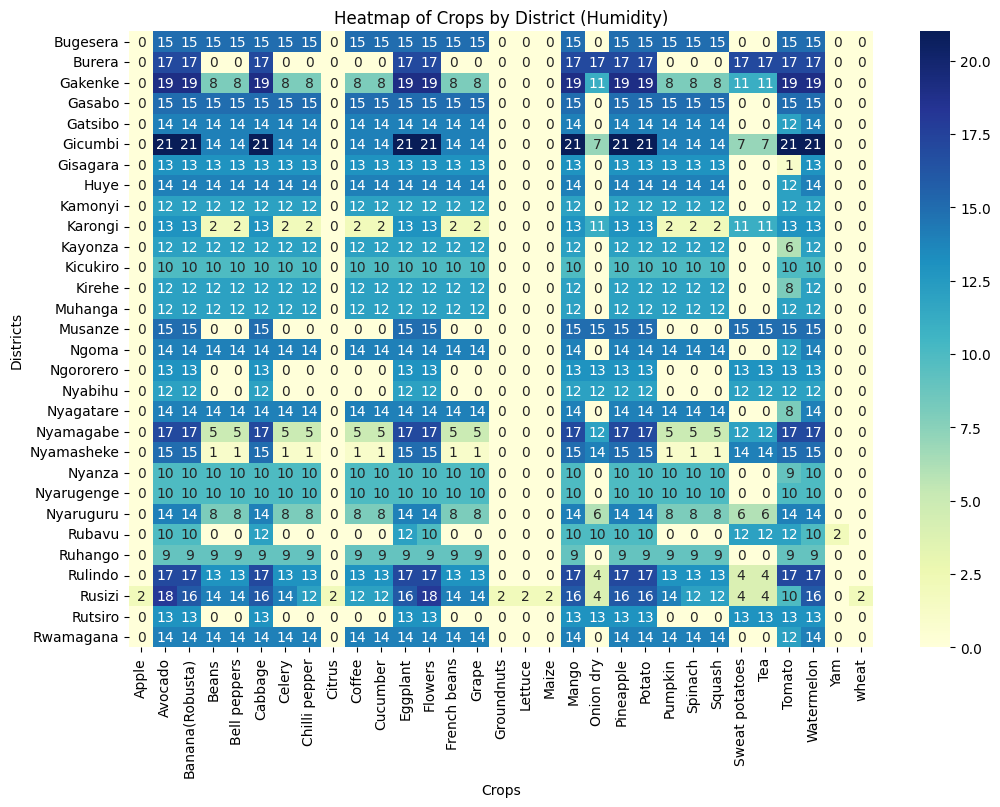

In [266]:
crops_per_district_humidity = merged_data_humidity.groupby(['District', 'Crop']).size().reset_index(name='Count')
heatmap_data_humidity = crops_per_district_humidity.pivot(index="District", columns="Crop", values="Count").fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_humidity, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Heatmap of Crops by District (Humidity)')
plt.xlabel('Crops')
plt.ylabel('Districts')
plt.show()

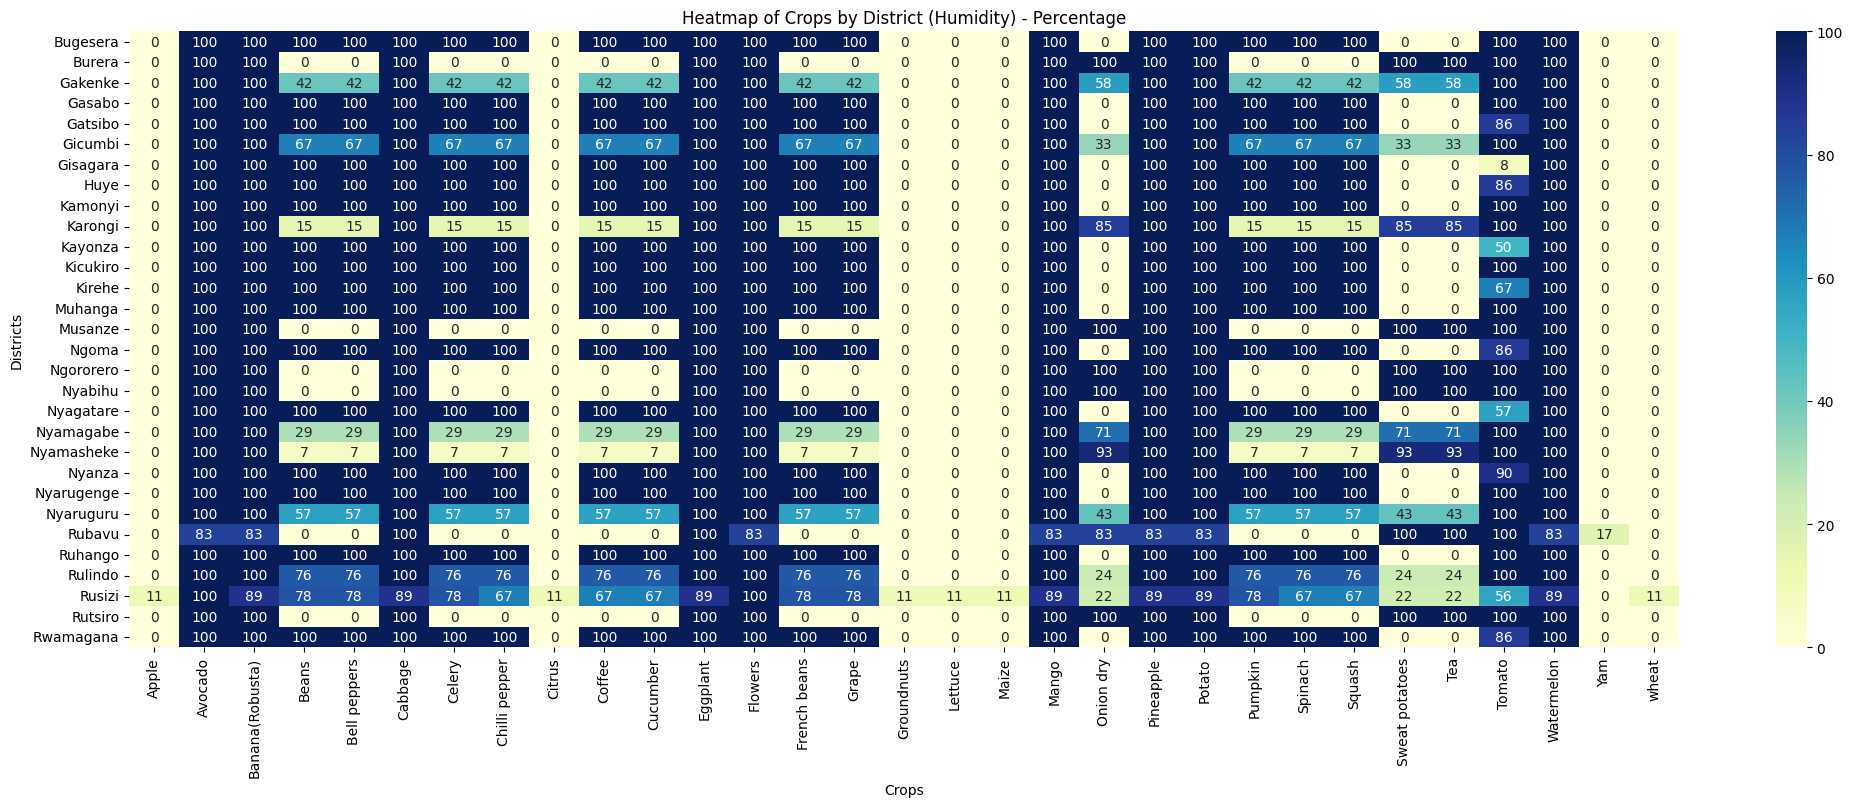

In [267]:
# Group by 'District' and 'Crop' to get the count of each crop in each district
crops_per_district_humidity = merged_data_humidity.groupby(['District', 'Crop']).size().reset_index(name='Count')

# Calculate the total number of sectors per district (ignore crops)
total_sectors_per_district.columns = ['District', 'Total_Sectors']

# Merge the crop counts with the total number of sectors per district
crops_per_district_humidity = crops_per_district_humidity.merge(total_sectors_per_district, on='District')

# Calculate the percentage of each crop in each district
crops_per_district_humidity['Percentage'] = (crops_per_district_humidity['Count'] / crops_per_district_humidity['Total_Sectors']) * 100

# Pivot to create a dataframe suitable for heatmap visualization
heatmap_data_humidity = crops_per_district_humidity.pivot(index="District", columns="Crop", values="Percentage").fillna(0)

# Create the heatmap with reduced decimal places
plt.figure(figsize=(25, 8))
sns.heatmap(heatmap_data_humidity, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Heatmap of Crops by District (Humidity) - Percentage')
plt.xlabel('Crops')
plt.ylabel('Districts')
plt.show()

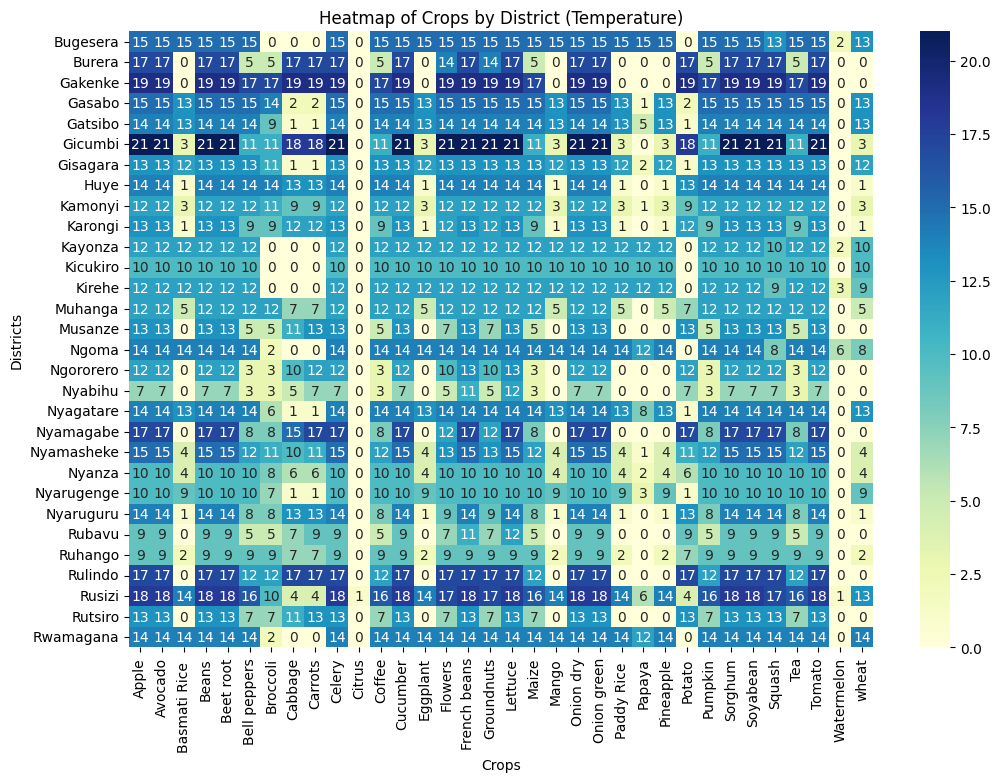

In [268]:
crops_per_district_temperature = merged_data_temperature.groupby(['District', 'Crop']).size().reset_index(name='Count')
heatmap_data_temperature = crops_per_district_temperature.pivot(index="District", columns="Crop", values="Count").fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_temperature, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Heatmap of Crops by District (Temperature)')
plt.xlabel('Crops')
plt.ylabel('Districts')
plt.show()

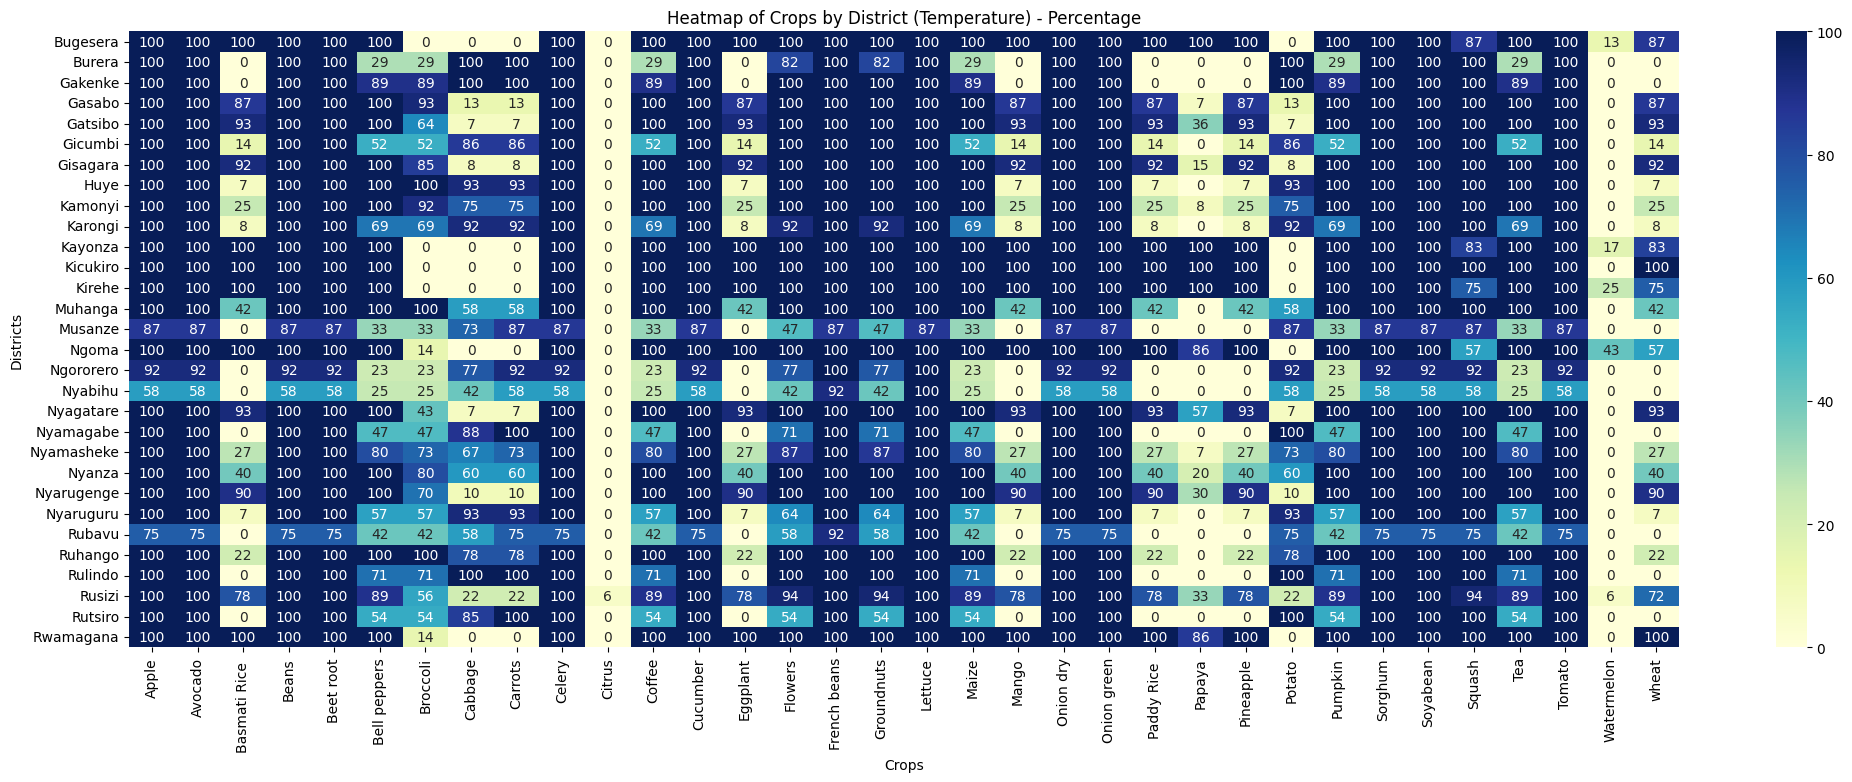

In [269]:
# Group by 'District' and 'Crop' to get the count of each crop in each district
crops_per_district_temperature = merged_data_temperature.groupby(['District', 'Crop']).size().reset_index(name='Count')

# Calculate the total number of sectors per district (ignore crops)
total_sectors_per_district.columns = ['District', 'Total_Sectors']

# Merge the crop counts with the total number of sectors per district
crops_per_district_temperature = crops_per_district_temperature.merge(total_sectors_per_district, on='District')

# Calculate the percentage of each crop in each district
crops_per_district_temperature['Percentage'] = (crops_per_district_temperature['Count'] / crops_per_district_temperature['Total_Sectors']) * 100

# Pivot to create a dataframe suitable for heatmap visualization
heatmap_data_temperature = crops_per_district_temperature.pivot(index="District", columns="Crop", values="Percentage").fillna(0)

# Create the heatmap with reduced decimal places
plt.figure(figsize=(25, 8))
sns.heatmap(heatmap_data_temperature, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Heatmap of Crops by District (Temperature) - Percentage')
plt.xlabel('Crops')
plt.ylabel('Districts')
plt.show()

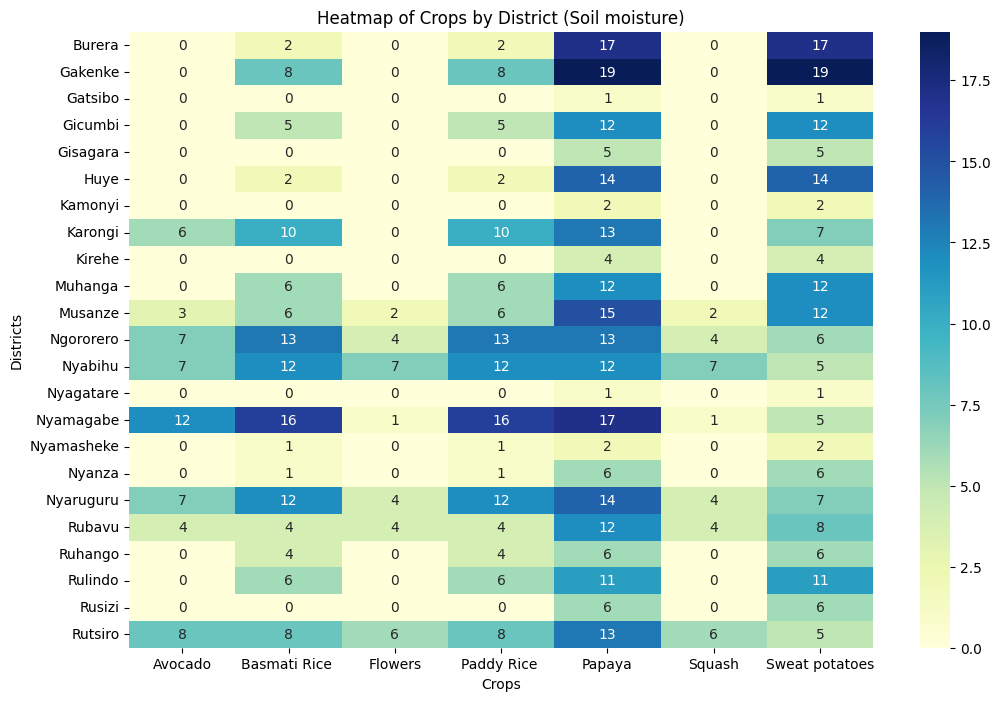

In [270]:
crops_per_district_moisture = merged_data_moisture.groupby(['District', 'Crop']).size().reset_index(name='Count')
heatmap_data_moisture = crops_per_district_moisture.pivot(index="District", columns="Crop", values="Count").fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_moisture, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Heatmap of Crops by District (Soil moisture)')
plt.xlabel('Crops')
plt.ylabel('Districts')
plt.show()

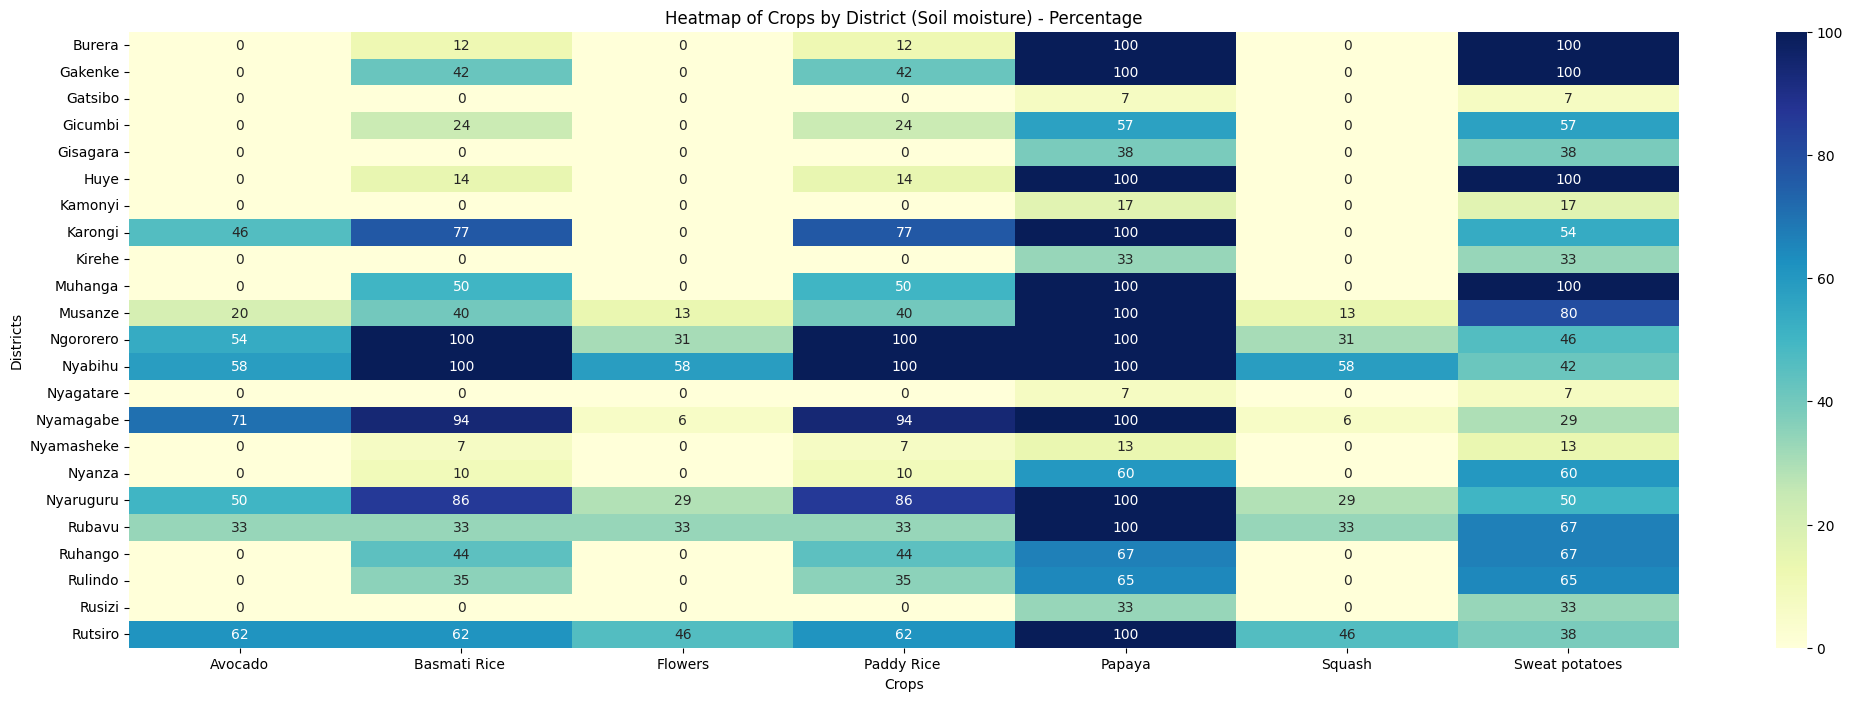

In [271]:
# Group by 'District' and 'Crop' to get the count of each crop in each district
crops_per_district_moisture = merged_data_moisture.groupby(['District', 'Crop']).size().reset_index(name='Count')

# Calculate the total number of sectors per district (ignore crops)
total_sectors_per_district.columns = ['District', 'Total_Sectors']

# Merge the crop counts with the total number of sectors per district
crops_per_district_moisture = crops_per_district_moisture.merge(total_sectors_per_district, on='District')

# Calculate the percentage of each crop in each district
crops_per_district_moisture['Percentage'] = (crops_per_district_moisture['Count'] / crops_per_district_moisture['Total_Sectors']) * 100

# Pivot to create a dataframe suitable for heatmap visualization
heatmap_data_moisture = crops_per_district_moisture.pivot(index="District", columns="Crop", values="Percentage").fillna(0)

# Create the heatmap with reduced decimal places
plt.figure(figsize=(25, 8))
sns.heatmap(heatmap_data_moisture, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Heatmap of Crops by District (Soil moisture) - Percentage')
plt.xlabel('Crops')
plt.ylabel('Districts')
plt.show()

In [272]:
# # Create a dictionary to hold filtered dataframes for each feature
# filtered_data = {}

# # List of features and their respective dataframes
# features = ['Potassium', 'pH', 'Phosphorus', 'Humidity', 'Temperature', 'Soil moisture']
# dataframes = [crops_per_district_potassium, crops_per_district_ph, crops_per_district_phosphorus, 
#               crops_per_district_humidity, crops_per_district_temperature, crops_per_district_moisture]

# # Filter crops with a percentage of at least 25% for each feature
# for feature, df in zip(features, dataframes):
#     filtered_data[feature] = df[df['Percentage'] >= 25].copy()

# # Prepare an empty dataframe for the summary
# summary_data = pd.DataFrame()

# # Collect best crops for each feature per district
# for feature, df in filtered_data.items():
#     # Find the crop with the highest percentage in each district
#     best_crops_per_district = df.loc[df.groupby('District')['Percentage'].idxmax()].copy()
#     best_crops_per_district['Feature'] = feature
#     summary_data = pd.concat([summary_data, best_crops_per_district[['District', 'Crop', 'Percentage', 'Feature']]])

# # Pivot the summary for better readability
# summary_pivot = summary_data.pivot_table(index='District', columns='Feature', values='Crop', aggfunc=lambda x: ' & '.join(x)).reset_index()

# # Write each feature's filtered crops and the summary to an Excel file
# with pd.ExcelWriter("Best_Crops_Per_District.xlsx") as writer:
#     for feature, df in filtered_data.items():
#         df.to_excel(writer, sheet_name=f"{feature}_Crops", index=False)
#     summary_pivot.to_excel(writer, sheet_name="Summary_Best_Crops", index=False)

# print("Excel file 'Best_Crops_Per_District.xlsx' has been generated with the best crops per district for each feature.")

In [273]:
merged_data_potassium['Temperature_max']

0       26.0
1       26.0
2       26.0
3       26.0
4       26.0
        ... 
4458    22.0
4459    22.0
4460    22.0
4461    22.0
4462    22.0
Name: Temperature_max, Length: 4463, dtype: float64

In [274]:
# Define a list to store normalized dataframes for each feature
normalized_data_frames = []
features = ['Potassium', 'pH', 'Phosphorus', 'Humidity', 'Temperature', 'Moisture']

# Normalize and store data for each feature
for feature, df in zip(features, [merged_data_potassium, merged_data_ph, merged_data_phosphorus,
                                  merged_data_humidity, merged_data_temperature, merged_data_moisture]):
    # Group by 'District' and 'Crop' to get the percentage
    crops_per_district = df.groupby(['District', 'Crop']).size().reset_index(name='Count')
    crops_per_district = crops_per_district.merge(total_sectors_per_district, on='District')
    crops_per_district['Percentage'] = (crops_per_district['Count'] / crops_per_district['Total_Sectors']) * 100
    
    # Normalize the percentage scores between 0 and 1
    scaler = MinMaxScaler()
    crops_per_district['Normalized_Percentage'] = scaler.fit_transform(crops_per_district[['Percentage']])
    
    # Store the feature name for reference
    crops_per_district['Feature'] = feature
    
    # Append the normalized data to the list
    normalized_data_frames.append(crops_per_district[['District', 'Crop', 'Normalized_Percentage', 'Feature']])

# Concatenate all normalized data into a single DataFrame
combined_data = pd.concat(normalized_data_frames)

# Pivot to get a table with each feature as a column
combined_data_pivot = combined_data.pivot_table(index=['District', 'Crop'], columns='Feature', 
                                                values='Normalized_Percentage', fill_value=0)

# Sum across all feature columns to get an aggregate score for each crop in each district
combined_data_pivot['Total_Score'] = combined_data_pivot.sum(axis=1)

# Reset index to make District and Crop columns again
combined_data_pivot = combined_data_pivot.reset_index()

# Apply the 75% threshold rule to select crops
# Get the maximum score for each district
max_scores_per_district = combined_data_pivot.groupby('District')['Total_Score'].max().reset_index()
max_scores_per_district.rename(columns={'Total_Score': 'Max_Score'}, inplace=True)

# Merge to get the max score for each district
combined_data_pivot = combined_data_pivot.merge(max_scores_per_district, on='District')

# Calculate the 75% threshold
combined_data_pivot['Score_Threshold'] = combined_data_pivot['Max_Score'] * 0.75

# Select crops that meet or exceed the 75% threshold
suitable_crops_per_district = combined_data_pivot[
    combined_data_pivot['Total_Score'] >= combined_data_pivot['Score_Threshold']
]

# # Create an Excel writer to save results
# output_file = "suitable_crops_per_district2.xlsx"
# with pd.ExcelWriter(output_file) as writer:
#     # Save each normalized feature data to a separate sheet
#     for feature, df in zip(features, normalized_data_frames):
#         df.to_excel(writer, sheet_name=f'{feature}', index=False)
    
#     # Save the summary sheet with the suitable crops per district
#     suitable_crops_per_district[['District', 'Crop', 'Total_Score']].to_excel(writer, sheet_name='Summary_Suitable_Crops', index=False)

# print(f"Results saved to {output_file}")


In [275]:
merged_data_potassium['Temperature_max']

0       26.0
1       26.0
2       26.0
3       26.0
4       26.0
        ... 
4458    22.0
4459    22.0
4460    22.0
4461    22.0
4462    22.0
Name: Temperature_max, Length: 4463, dtype: float64

Final dataset
----

In [276]:
# Step 1: Get a list of best crops from the suitable_crops_per_district DataFrame
best_crops = suitable_crops_per_district['Crop'].unique()

# Step 2: Filter the base_data to include only the best crops
final_dataset = base_data[base_data['Crop'].isin(best_crops)]

# Step 3: Remove the specified columns from the filtered dataset
columns_to_remove = [
    'Id','Crop suitability', 'Acid Saturation(%)', 'AcidSat', 'Boron (ppm)', 'Calcium(%)', 
    'Calcium(ppm)', 'Copper (ppm)', 'Magnessium(%)', 'Magnessium(ppm)', 
    'Manganese(ppm)', 'Manganese', 'Organic Matter(%)', 'Phosphorous(ppm)', 
    'Potassium (%)', 'Potassium(ppm)', 'Sulphur (ppm)', 'Zinc (ppm)', 'temperature (C)', 'pH', 'Optimum soil moisture', 'Humidity(%)'
]

In [277]:
# Function to convert ranges into mean values
def convert_to_mean(value):
    if isinstance(value, float) or pd.isna(value):
        # If the value is already a float (or NaN), return it as is
        return value
    elif '-' in value:
        # If the value contains a range like "500-700", compute the mean
        low, high = value.split('-')
        return (float(low) + float(high)) / 2
    elif '>' in value:
        # If the value contains ">", return the minimum possible value plus a small buffer (e.g., 50)
        return float(value.replace('>', '').strip()) + 50
    else:
        # For single values, return as float
        return float(value.strip())

# Apply conversion to 'Annual rainfall (mm)' column
final_dataset['Annual rainfall (mm)'] = final_dataset['Annual rainfall (mm)'].apply(convert_to_mean)

# Apply conversion to 'Irrigation required(%)' column
final_dataset['Irrigation required(%)'] = final_dataset['Irrigation required(%)'].apply(convert_to_mean)

# Apply conversion to 'Crop water need (mm/total growing period)' column
final_dataset['Crop water need (mm/total growing period)'] = final_dataset['Crop water need (mm/total growing period)'].apply(convert_to_mean)

# Apply conversion to 'Growing period (days)' column
final_dataset['Growing period (days)'] = final_dataset['Growing period (days)'].apply(convert_to_mean)

C:\Users\robot\AppData\Local\Temp\ipykernel_17192\2698252686.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset['Annual rainfall (mm)'] = final_dataset['Annual rainfall (mm)'].apply(convert_to_mean)
C:\Users\robot\AppData\Local\Temp\ipykernel_17192\2698252686.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset['Irrigation required(%)'] = final_dataset['Irrigation required(%)'].apply(convert_to_mean)
C:\Users\robot\AppData\Local\Temp\ipykernel_17192\2698252686.py:24: SettingWit

In [278]:
# Fill any remaining NaN values in numerical columns with the median value
numeric_cols = ['Annual rainfall (mm)', 'Irrigation required(%)']
final_dataset[numeric_cols] = final_dataset[numeric_cols].fillna(final_dataset[numeric_cols].median())

C:\Users\robot\AppData\Local\Temp\ipykernel_17192\3146261460.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset[numeric_cols] = final_dataset[numeric_cols].fillna(final_dataset[numeric_cols].median())


In [279]:
# Mapping similar soil types to common categories
soil_mapping = {
    r'.*well[-\s]*drain.*': 'Well-drained',
    r'.*sandy.*loam.*': 'Sandy Loam',
    r'.*loam.*clay.*': 'Clay Loam',
    r'.*loamy.*': 'Loamy',
    r'.*sandy.*': 'Sandy',
    r'.*volcanic.*': 'Volcanic',
    r'.*alluvial.*': 'Alluvial'
}

# Clean the 'Soil type' column using regex mapping
final_dataset['Soil type'] = final_dataset['Soil type'].str.lower()
for pattern, replacement in soil_mapping.items():
    final_dataset['Soil type'] = final_dataset['Soil type'].str.replace(pattern, replacement, regex=True)

C:\Users\robot\AppData\Local\Temp\ipykernel_17192\1860328962.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset['Soil type'] = final_dataset['Soil type'].str.lower()
C:\Users\robot\AppData\Local\Temp\ipykernel_17192\1860328962.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset['Soil type'] = final_dataset['Soil type'].str.replace(pattern, replacement, regex=True)


In [280]:
# Function to split rows with multiple start/end months into separate rows
def expand_crop_calendar(final_dataset):
    rows = []
    for _, row in final_dataset.iterrows():
        start_months = row['Crop calendar start (month)'].replace(' ', '').split(',')
        end_months = row['Crop calendar end (month)'].replace(' ', '').split(',')
        
        # Ensure we match start and end seasons properly
        for start, end in zip(start_months, end_months):
            new_row = row.copy()
            new_row['Crop calendar start (month)'] = start.strip()
            new_row['Crop calendar end (month)'] = end.strip()
            rows.append(new_row)
    
    return pd.DataFrame(rows)

# Apply the function to expand the dataset
final_dataset = expand_crop_calendar(final_dataset)

In [281]:
# Fill missing numeric values with the median
numeric_cols = final_dataset.select_dtypes(include=['float64', 'int64']).columns
final_dataset[numeric_cols] = final_dataset[numeric_cols].fillna(final_dataset[numeric_cols].median())

# Fill missing categorical values with the mode or 'Unknown'
categorical_cols = final_dataset.select_dtypes(include=['object']).columns
final_dataset[categorical_cols] = final_dataset[categorical_cols].fillna('Unknown')

In [282]:
# Label encode soil types
final_dataset['Soil type'] = final_dataset['Soil type'].astype('category').cat.codes

# One-hot encode start and end months if needed
final_dataset = pd.get_dummies(final_dataset, columns=['Crop calendar start (month)', 'Crop calendar end (month)'])


In [283]:
# Drop the specified columns
final_dataset = final_dataset.drop(columns=columns_to_remove, errors='ignore')

# Step 4: Save the filtered data to an Excel file
output_file_path = 'final_dataset.xlsx'
final_dataset.to_excel(output_file_path, index=False)

print(f"Filtered data saved to {output_file_path}")

Filtered data saved to final_dataset.xlsx


In [284]:
data = final_dataset

In [285]:
# Sample function to convert range strings into their averages
def convert_range_to_average(value):
    if isinstance(value, str) and '-' in value:
        # Split the range and convert to float
        low, high = value.split('-')
        return (float(low) + float(high)) / 2
    else:
        # Return the value as is (converting to float if it's numeric)
        try:
            return float(value)
        except ValueError:
            return np.nan

# Apply this function to the N, P, and K columns
data['N'] = data['N'].apply(convert_range_to_average)
data['P'] = data['P'].apply(convert_range_to_average)
data['K'] = data['K'].apply(convert_range_to_average)

In [286]:
data.columns

Index(['Crop', 'Crop type', 'Altitude (masl)', 'Annual rainfall (mm)',
       'Soil type', 'N', 'P', 'K', 'Crop water need (mm/total growing period)',
       'Growing period (days)', 'Irrigation required(%)', 'Humidity_min',
       'Humidity_max', 'Temperature_min', 'Temperature_max', 'Moisture_min',
       'Moisture_max', 'Longitude', 'Latitude', 'Prov_ID', 'Province',
       'Dist_ID', 'District', 'Sect_ID', 'Sector', 'Humidity', 'Rainfall',
       'Temperature', 'Elevation', 'Soil_Moisture', 'potassium_min',
       'potassium_max', 'phosphorus_min', 'phosphorus_max', 'pH_min', 'pH_max',
       'Crop calendar start (month)_April',
       'Crop calendar start (month)_August',
       'Crop calendar start (month)_February',
       'Crop calendar start (month)_January',
       'Crop calendar start (month)_July',
       'Crop calendar start (month)_November',
       'Crop calendar start (month)_October',
       'Crop calendar start (month)_September',
       'Crop calendar start (month)_Y

In [287]:
# # Encode categorical columns
# encoder = LabelEncoder()
# data['Crop'] = encoder.fit_transform(data['Crop'])
# data['Crop type'] = encoder.fit_transform(data['Crop type'])
# data['Province'] = encoder.fit_transform(data['Province'])
# data['District'] = encoder.fit_transform(data['District'])
# data['Sector'] = encoder.fit_transform(data['Sector'])

# # Normalize numerical features
# scaler = StandardScaler()
# numerical_features = ['Altitude (masl)', 'Annual rainfall (mm)', 'N', 'P', 'K',
#                       'Crop water need (mm/total growing period)', 'Growing period (days)',
#                       'Humidity_min', 'Humidity_max', 'Temperature_min', 'Temperature_max',
#                       'Moisture_min', 'Moisture_max', 'Longitude', 'Latitude', 'Elevation', 
#                       'Soil_Moisture', 'potassium_min', 'potassium_max', 'phosphorus_min', 
#                       'phosphorus_max', 'pH_min', 'pH_max']

# data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [288]:
# # Define features (X) and target (y)
# X = data.drop(['Crop', 'Crop type'], axis=1)
# y = data['Crop']

# # Impute missing values for numerical columns
# imputer = SimpleImputer(strategy='mean')
# X_imputed = imputer.fit_transform(X)

# # Stratified split to ensure all crop types are represented
# strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# for train_idx, test_idx in strat_split.split(X_imputed, y):
#     X_train = X_imputed[train_idx]
#     X_test = X_imputed[test_idx]
#     y_train = y.iloc[train_idx]
#     y_test = y.iloc[test_idx]

# # Train models with cross-validation to assess performance
# def evaluate_model(model, X_train, y_train, X_test, y_test):
#     model.fit(X_train, y_train)
#     train_score = cross_val_score(model, X_train, y_train, cv=5).mean()
#     y_pred = model.predict(X_test)
#     test_score = accuracy_score(y_test, y_pred)
#     return train_score, test_score

# # Random Forest
# rf_model = RandomForestClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)
# rf_train_score, rf_test_score = evaluate_model(rf_model, X_train, y_train, X_test, y_test)

# # Decision Tree
# dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)
# dt_train_score, dt_test_score = evaluate_model(dt_model, X_train, y_train, X_test, y_test)

# # SVM
# svm_model = SVC(C=0.1, kernel='linear', random_state=42)
# svm_train_score, svm_test_score = evaluate_model(svm_model, X_train, y_train, X_test, y_test)

# # XGBoost
# xgb_model = XGBClassifier(max_depth=6, reg_alpha=0.1, reg_lambda=0.1, n_estimators=100, random_state=42)
# xgb_train_score, xgb_test_score = evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

# # Compare accuracy scores
# print(f"Random Forest - Train Accuracy: {rf_train_score}, Test Accuracy: {rf_test_score}")
# print(f"Decision Tree - Train Accuracy: {dt_train_score}, Test Accuracy: {dt_test_score}")
# print(f"SVM - Train Accuracy: {svm_train_score}, Test Accuracy: {svm_test_score}")
# print(f"XGBoost - Train Accuracy: {xgb_train_score}, Test Accuracy: {xgb_test_score}")

In [289]:
# Ensure district and sector columns are strings before fitting
data['District'] = data['District'].astype(str)
data['Sector'] = data['Sector'].astype(str)

# Fit the encoders with string values
district_encoder = LabelEncoder()
district_encoder.fit(data['District'])

sector_encoder = LabelEncoder()
sector_encoder.fit(data['Sector'])

LabelEncoder()

In [290]:
# # Example user inputs
# user_inputs = {
#     "district": "Gasabo",
#     "sector": "Bumbogo",
#     "start_date_to_plant": "2024-02-01"
# }

# # Extract the month from the start_date_to_plant
# start_date_to_plant = user_inputs['start_date_to_plant']
# start_month = datetime.strptime(start_date_to_plant, "%Y-%m-%d").strftime("%B")  # Get the full month name

# # Initialize encoders
# district_encoder = LabelEncoder()
# sector_encoder = LabelEncoder()

# # Fit encoders on the original string data
# district_encoder.fit(data['District'].astype(str))
# sector_encoder.fit(data['Sector'].astype(str))

# numerical_features = ['Altitude (masl)', 'Annual rainfall (mm)', 'N', 'P', 'K',
#                       'Crop water need (mm/total growing period)', 'Growing period (days)',
#                       'Humidity_min', 'Humidity_max', 'Temperature_min', 'Temperature_max',
#                       'Moisture_min', 'Moisture_max', 'Longitude', 'Latitude', 'Elevation', 
#                       'Soil_Moisture', 'potassium_min', 'potassium_max', 'phosphorus_min', 
#                       'phosphorus_max', 'pH_min', 'pH_max']

# data[numerical_features] = scaler.fit_transform(data[numerical_features])

# # Encode categorical columns for model training
# data['District_encoded'] = district_encoder.transform(data['District'].astype(str))
# data['Sector_encoded'] = sector_encoder.transform(data['Sector'].astype(str))

# def prepare_user_data(user_inputs, data, district_encoder, sector_encoder, scaler, numerical_imputer):
#     # Convert user input to lowercase to match training data format
#     district = user_inputs['district'].strip()
#     sector = user_inputs['sector'].strip()
#     start_date_to_plant = user_inputs['start_date_to_plant']

#     # Extract the month from the start date
#     start_month = datetime.strptime(start_date_to_plant, "%Y-%m-%d").strftime("%B")

#     # Convert the training data columns to strings and then to lowercase
#     data['District'] = data['District'].astype(str)
#     data['Sector'] = data['Sector'].astype(str)

#     # Check if district and sector are known
#     if district not in district_encoder.classes_ or sector not in sector_encoder.classes_:
#         raise ValueError(f"District '{district}' or sector '{sector}' not found in training data.")

#     # Encode the district and sector
#     user_district_encoded = district_encoder.transform([district])[0]
#     user_sector_encoded = sector_encoder.transform([sector])[0]

#     # Filter for numerical defaults based on district and sector
#     filtered_data = data[(data['District'] == district) & (data['Sector'] == sector)]
#     if filtered_data.empty:
#         filtered_data = data[data['District'] == district]

#     # Prepare user data with encoded and default values
#     user_data = {
#         'District_encoded': user_district_encoded,
#         'Sector_encoded': user_sector_encoded,
#     }

#     for feature in numerical_features:
#         # Get mean value from filtered data if available, otherwise set to NaN
#         user_data[feature] = filtered_data[feature].mean() if feature in filtered_data.columns else np.nan

#     # Set crop calendar boolean flags based on the start month
#     user_data[f'Crop calendar start (month)_{start_month}'] = True
#     user_data['Crop calendar end (month)_' + start_month] = True  # Assuming the planting and harvesting can happen in the same month

#     # Create DataFrame for user data
#     user_df = pd.DataFrame([user_data])

#     # Impute missing values for numerical data
#     user_df[numerical_features] = numerical_imputer.transform(user_df[numerical_features])

#     # Normalize numerical features using the scaler
#     user_df = user_df.reindex(columns=X_train.columns, fill_value=0)  # Ensure all columns are included
#     user_df[numerical_features] = scaler.transform(user_df[numerical_features])

#     return user_df


# def is_valid_crop_for_month(predicted_crop, start_month, data):
#     """ Check if the predicted crop can be planted in the given month. """
#     # Find the relevant crop calendar columns
#     start_column = f'Crop calendar start (month)_{start_month}'
    
#     # Check if the crop exists in the data and if it has a valid planting month
#     if predicted_crop in data['Crop'].values:  # Assuming 'Crop' is the column for crop names
#         crop_row = data[data['Crop'] == predicted_crop]
#         return crop_row[start_column].values[0]  # Returns True/False
#     return False  # If crop is not found

# # Prepare user data
# user_df = prepare_user_data(user_inputs, data, district_encoder, sector_encoder, scaler, imputer)

# # Train and evaluate models
# def evaluate_model(model, X_train, y_train, X_test, y_test):
#     model.fit(X_train, y_train)
#     train_score = cross_val_score(model, X_train, y_train, cv=5).mean()
#     y_pred = model.predict(X_test)
#     test_score = accuracy_score(y_test, y_pred)
#     return train_score, test_score

# # Random Forest Model
# rf_model = RandomForestClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)
# rf_train_score, rf_test_score = evaluate_model(rf_model, X_train, y_train, X_test, y_test)

# # Decision Tree
# dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)
# dt_train_score, dt_test_score = evaluate_model(dt_model, X_train, y_train, X_test, y_test)

# # Make a prediction using the Random Forest model
# user_prediction = rf_model.predict(user_df)
# predicted_crop = user_prediction[0]

# # Make a prediction using the Decision tree model
# user_prediction_dt = dt_model.predict(user_df)
# predicted_crop_dt = user_prediction_dt[0]

# # Validate the predicted crop against the user input
# if is_valid_crop_for_month(predicted_crop, start_month, data):
#     print(f"Predicted Crop for the given inputs: {predicted_crop}")
# else:
#     print(f"The predicted crop '{predicted_crop}' is not suitable for planting in {start_month}.")

In [291]:
# Example user inputs
user_inputs = {
    "district": "Gasabo",
    "sector": "Bumbogo",
    "start_date_to_plant": "2024-02-01"
}

# Extract the month from the start_date_to_plant
start_date_to_plant = user_inputs['start_date_to_plant']
start_month = datetime.strptime(start_date_to_plant, "%Y-%m-%d").strftime("%B")  # Get the full month name

# Initialize encoders
district_encoder = LabelEncoder()
sector_encoder = LabelEncoder()

# Fit encoders on the original string data
district_encoder.fit(data['District'].astype(str))
sector_encoder.fit(data['Sector'].astype(str))

# Define numerical features
numerical_features = ['Altitude (masl)', 'Annual rainfall (mm)', 'N', 'P', 'K',
                      'Crop water need (mm/total growing period)', 'Growing period (days)',
                      'Humidity_min', 'Humidity_max', 'Temperature_min', 'Temperature_max',
                      'Moisture_min', 'Moisture_max', 'Longitude', 'Latitude', 'Elevation', 
                      'Soil_Moisture', 'potassium_min', 'potassium_max', 'phosphorus_min', 
                      'phosphorus_max', 'pH_min', 'pH_max']

# Fit and transform numerical features
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Encode categorical columns for model training
data['District_encoded'] = district_encoder.transform(data['District'].astype(str))
data['Sector_encoded'] = sector_encoder.transform(data['Sector'].astype(str))

def prepare_user_data(user_inputs, data, district_encoder, sector_encoder, scaler, numerical_imputer):
    # Convert user input to lowercase to match training data format
    district = user_inputs['district'].strip()
    sector = user_inputs['sector'].strip()
    
    # Extract the month from the start date
    start_date_to_plant = user_inputs['start_date_to_plant']
    start_month = datetime.strptime(start_date_to_plant, "%Y-%m-%d").strftime("%B")

    # Convert the training data columns to strings and then to lowercase
    data['District'] = data['District'].astype(str)
    data['Sector'] = data['Sector'].astype(str)

    # Check if district and sector are known
    if district not in district_encoder.classes_ or sector not in sector_encoder.classes_:
        raise ValueError(f"District '{district}' or sector '{sector}' not found in training data.")

    # Encode the district and sector
    user_district_encoded = district_encoder.transform([district])[0]
    user_sector_encoded = sector_encoder.transform([sector])[0]

    # Filter for numerical defaults based on district and sector
    filtered_data = data[(data['District'] == district) & (data['Sector'] == sector)]
    if filtered_data.empty:
        filtered_data = data[data['District'] == district]

    # Prepare user data with encoded and default values
    user_data = {
        'District_encoded': user_district_encoded,
        'Sector_encoded': user_sector_encoded,
    }

    for feature in numerical_features:
        # Get mean value from filtered data if available, otherwise set to NaN
        if feature in filtered_data.columns and not filtered_data[feature].isnull().all():
            user_data[feature] = filtered_data[feature].mean()
        else:
            user_data[feature] = np.nan  # Default to NaN if no valid data

    # Set crop calendar boolean flags based on the start month
    user_data[f'Crop calendar start (month)_{start_month}'] = True
    user_data['Crop calendar end (month)_' + start_month] = True  # Assuming planting and harvesting can happen in the same month

    # Create DataFrame for user data
    user_df = pd.DataFrame([user_data])

    # Impute missing values for numerical data
    user_df[numerical_features] = numerical_imputer.transform(user_df[numerical_features])

    # Normalize numerical features using the scaler
    user_df = user_df.reindex(columns=X_train.columns, fill_value=0)  # Ensure all columns are included
    user_df[numerical_features] = scaler.transform(user_df[numerical_features])

    return user_df

# Prepare user data
user_df = prepare_user_data(user_inputs, data, district_encoder, sector_encoder, scaler, imputer)

# Train and evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_score = cross_val_score(model, X_train, y_train, cv=5).mean()
    y_pred = model.predict(X_test)
    test_score = accuracy_score(y_test, y_pred)
    return train_score, test_score

# Random Forest Model
rf_model = RandomForestClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)
rf_train_score, rf_test_score = evaluate_model(rf_model, X_train, y_train, X_test, y_test)

# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)
dt_train_score, dt_test_score = evaluate_model(dt_model, X_train, y_train, X_test, y_test)

# Get predictions for the top 5 crops
def get_top_crops(model, user_df, data, n=5):
    results = []
    # Get probabilities for all crops
    crop_probabilities = model.predict_proba(user_df)  # Returns probabilities for all classes
    top_indices = np.argsort(crop_probabilities[0])[::-1][:n]  # Get indices of top n crops

    for index in top_indices:
        crop = model.classes_[index]  # Get the crop name using the index
        crop_probability = crop_probabilities[0][index]  # Probability of the predicted crop

        # Assuming you want to get crop details
        crop_details = data[data['Crop'] == crop].iloc[0]  # This should be safe if crop exists
        result = {
            "crop": crop,
            "crop_type": crop_details.get("Crop Type", "Unknown"),
            "general_accuracy_score": crop_probability,  # Use the specific crop probability
            "best_season": crop_details.get("Best_Season", "Unknown"),
            "irrigation_required": crop_details.get("Irrigation Required", "Unknown")
        }
        results.append(result)

    return results



# Get top 5 crops from Random Forest model
top_crops_rf = get_top_crops(rf_model, user_df, data)

# Print the results in the desired format
import json
print(json.dumps(top_crops_rf, indent=4))

NameError: name 'imputer' is not defined

Ignore the following cells
-----

In [ ]:
# Perform t-tests between crop and region variables
t_test_ph = stats.ttest_ind(merged_data_potassium['pH_min'], merged_data_ph['pH_min'], nan_policy='omit')
t_test_potassium = stats.ttest_ind(merged_data_potassium['potassium_min'], merged_data_ph['potassium_min'], nan_policy='omit')
t_test_phosphorus = stats.ttest_ind(merged_data_potassium['phosphorus_min'], merged_data_ph['phosphorus_min'], nan_policy='omit')

# Print results
print(f"T-test result for pH: {t_test_ph}")
print(f"T-test result for potassium: {t_test_potassium}")
print(f"T-test result for phosphorus: {t_test_phosphorus}")


T-test result for pH: Ttest_indResult(statistic=-29.990196511870316, pvalue=5.8498866189328e-190)
T-test result for potassium: Ttest_indResult(statistic=2.210542878609771, pvalue=0.027088169800514924)
T-test result for phosphorus: Ttest_indResult(statistic=2.287858774362602, pvalue=0.02216478012431401)


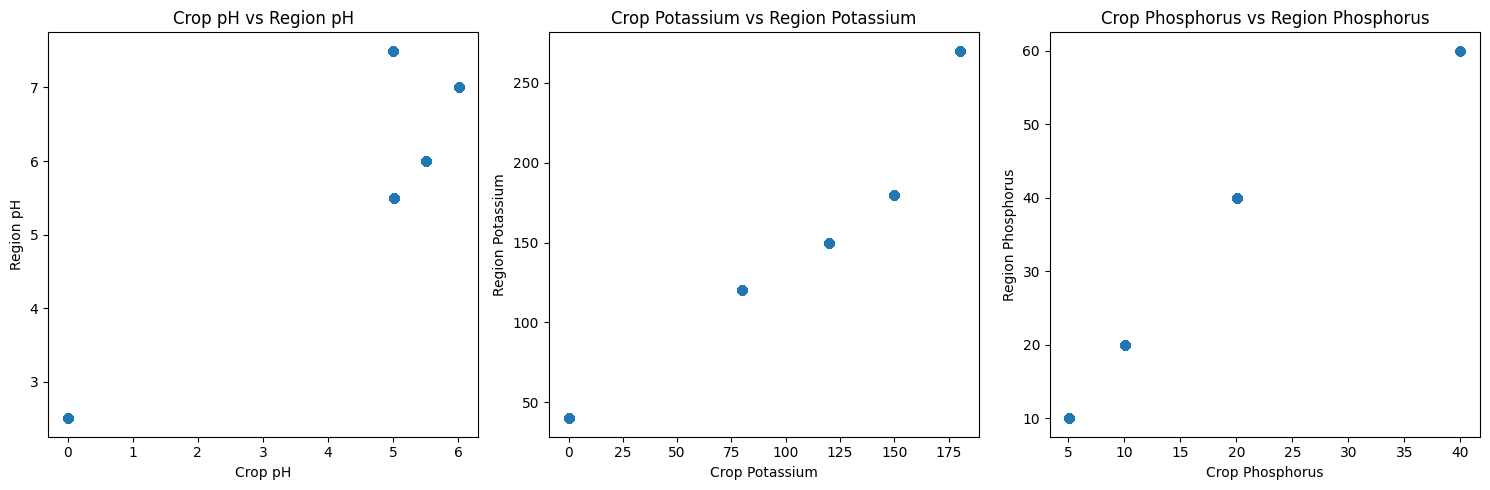

In [ ]:
# Scatter plot to visualize the relationship between crop and region values
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(merged_data_potassium['pH_min'], merged_data_potassium['pH_max'])
plt.title("Crop pH vs Region pH")
plt.xlabel('Crop pH')
plt.ylabel('Region pH')

plt.subplot(1, 3, 2)
plt.scatter(merged_data_potassium['potassium_min'], merged_data_potassium['potassium_max'])
plt.title("Crop Potassium vs Region Potassium")
plt.xlabel('Crop Potassium')
plt.ylabel('Region Potassium')

plt.subplot(1, 3, 3)
plt.scatter(merged_data_potassium['phosphorus_min'], merged_data_potassium['phosphorus_max'])
plt.title("Crop Phosphorus vs Region Phosphorus")
plt.xlabel('Crop Phosphorus')
plt.ylabel('Region Phosphorus')

plt.tight_layout()
plt.show()


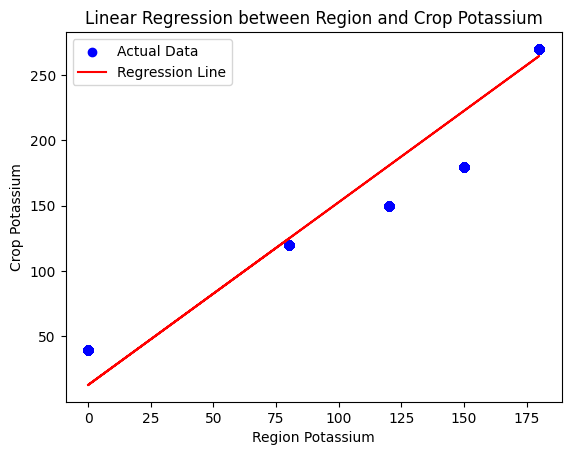

R-squared: 0.9275378903126481


In [ ]:
from sklearn.linear_model import LinearRegression

# Example: linear regression between crop potassium and region potassium
X = merged_data_potassium[['potassium_min']].values.reshape(-1, 1)  # Region Potassium
y = merged_data_potassium['potassium_max'].values  # Crop Potassium

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict and plot results
y_pred = model.predict(X)

plt.scatter(X, y, color='blue', label="Actual Data")
plt.plot(X, y_pred, color='red', label="Regression Line")
plt.title('Linear Regression between Region and Crop Potassium')
plt.xlabel('Region Potassium')
plt.ylabel('Crop Potassium')
plt.legend()
plt.show()

# Print the model's R-squared value to assess goodness of fit
print(f"R-squared: {model.score(X, y)}")


INTERPRETATIONS
-----
<b>1. P-value close to 1:</b>
A p-value is used to determine the significance of your results. A high p-value (close to 1) indicates that there is no significant difference between the crop and region data for the variables you tested. This suggests that the values between crop and region data for variables like pH, potassium, or phosphorus may not be meaningfully different, implying they could be related or similar.

<B>Interpretation</B>: If the p-value is close to 1, it means the data for crop and region are statistically similar, meaning there is no significant difference between them. Therefore, the null hypothesis (that the two data sets are similar) cannot be rejected.

<b>2. Correlation values in the range of 0.05:</b>

Correlation coefficients indicate the strength and direction of a linear relationship between two variables. Values in the range of 0.05 are very close to zero, meaning there is very weak or no linear relationship between the crop and region data for pH, potassium, or phosphorus.

<B>Interpretation</B>: Correlation values around 0.05 suggest that there is no strong linear relationship between the crop and region values. While these values might be statistically similar, they do not vary in a directly proportional or consistent way. In other words, knowing the region’s value doesn't strongly predict the crop’s value.

<b>3. R-squared: 0.67:</b>

The R-squared value represents how well the independent variable (e.g., region pH or region potassium) predicts the dependent variable (e.g., crop pH or crop potassium). An R-squared of 0.67 means that 67% of the variation in the crop data can be explained by the region data.

<B>Interpretation</B>: An R-squared of 0.67 indicates a moderate to strong relationship between the crop and region data for that variable (potassium, pH, etc.). This means that the region data explains a significant portion of the variation in crop data, but there is still 33% of the variation that is unexplained by this relationship.

<b>Overall Meaning:</b>

The p-value close to 1 suggests that the crop and region data are statistically similar.
The correlation near 0.05 indicates that while they may be similar, there is no strong linear relationship between them.
The R-squared of 0.67 suggests that a significant portion of the crop data can be explained by the region data, but it's not a perfect predictor.

<b>Suggested Next Steps:</b>

While there's some evidence that the region's pH, potassium, and phosphorus values might relate to the crop data, it's not a straightforward linear relationship. You might explore non-linear models or other techniques (like clustering or interaction terms in regression) to better capture the remaining unexplained variation.

You could also investigate other factors (e.g., soil type, climate, other nutrients) that might explain the variation in crop data.